# World Data League 2023

## 🎯 Challenge
* Avencas Marine Protected Area: Predict the future of the local ecosystem and its species


## Team: Insight Squad
## 👥 Authors
* Maria Castro
* Ricardo Filipe
* Rodrigo Ferreira
* Catarina Rocha
* Eduardo Vicente

## 💻 Development

##### Imports and Functions and Configuration

In [1]:
datasource_path = 'cascais_data'   # Path of the datasources
flag_run_pandaprofile = False            # Flag to identify if it is to run the panda profile report
flag_run_sweetviz = False
flag_save_dataframes = True             # Flag to save dataframe in a file 

In [2]:
%load_ext autotime

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import geopandas as gpd
import pickle
import os
from tqdm.auto import tqdm
from pqdm.processes import pqdm
#from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt, dates
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
from shapely.geometry import Point, Polygon
import json
from joblib import Parallel, delayed
import multiprocessing as mp
import datetime
import re
%matplotlib inline

time: 650 ms (started: 2023-05-17 14:48:40 +00:00)


In [3]:
# define a function to convert time fields to datetime.time
def convert_to_time(time_field):
    if isinstance(time_field, datetime.time):
        # if the input is already a datetime.time, return it as is
        return time_field
    elif isinstance(time_field, str):
        # if the input is a string, try to parse it as either HH:MM or HH.MM format
        try:
            return datetime.datetime.strptime(time_field, '%H:%M').time()
        except ValueError:
            try:
                return datetime.datetime.strptime(time_field, '%H.%M').time()
            except ValueError:
                pass
    elif isinstance(time_field, (int, float)):
        # if the input is a decimal number of percentage of the day, convert it to a datetime.time
        if 0 <= time_field <= 1:
            seconds = int(round(time_field * 86400))
            return datetime.time(seconds // 3600, (seconds % 3600) // 60, seconds % 60)
    # if none of the above conversions worked, return None
    return None

time: 1.24 ms (started: 2023-05-17 14:48:41 +00:00)


In [4]:
def get_season(month, day):
    # compute the season based on the month and day
    if (month == 12 and day >= 21) or (month <= 3):
        return 'winter'
    elif (month >= 3 and month <= 6) or (month == 7 and day < 22):
        return 'spring'
    elif (month >= 6 and month <= 9) or (month == 10 and day < 22):
        return 'summer'
    else:
        return 'fall'

time: 3.85 ms (started: 2023-05-17 14:48:41 +00:00)


In [5]:
def enr_date_fields(df, date_field_name, time_field_name):
    """
    Gets dataframe df that contains a columns with a datetime and adds to that dataframe the computation of
    date, day, month, year, week, hour, minute, day-of-week
        
    Parameters
    ----------
    df : the dataframe that contains the field datetime
    date_field_name: name of the dataframe's field that contains the information of the datime
        
    Returns
    -------
    returns a dataframe that is everything the same as the input dataframe, but now enriched with more date-related fields
    """
    
    _df = df.copy()
    _df['date'] = pd.to_datetime(_df[date_field_name], infer_datetime_format=True).dt.date
    _df['time'] = _df[time_field_name].apply(convert_to_time)
    _df['datetime'] = pd.to_datetime(_df['date'].astype(str) + ' ' + _df['time'].astype(str))
    _df['day']    = _df['datetime'].dt.day
    _df['month']  = _df['datetime'].dt.month
    _df['hour']   = _df['datetime'].dt.hour
    _df['minute'] = _df['datetime'].dt.minute
    _df['week'] = _df['datetime'].dt.week
    _df['weekyear'] = _df['datetime'].dt.strftime('%Y-%W')
    _df['weekyear'] = _df['datetime'].dt.strftime('%G-%V')
    
    
    _df['year'] = _df['datetime'].dt.year
    _df['day of the week'] = _df['datetime'].dt.weekday
    _df['season'] = _df.apply(lambda row: get_season(row['month'], row['day']), axis=1)
    _df = _df.drop([date_field_name, time_field_name], axis=1)
    
    return _df

time: 1.17 ms (started: 2023-05-17 14:48:41 +00:00)


In [6]:
def compare_dfs_in_column(df1, specie_col_df1, df2, specie_col_df2):
    
    species_df1 = df1[specie_col_df1].unique()
    species_df1_qtd = len(specie_col_df1)

    species_df2 = df2[specie_col_df2].unique()
    species_df2_qtd = len(specie_col_df2)

    print(f'Data measures has {species_df1_qtd} species, versus {species_df2_qtd} in the reference data')

    species_common = sorted(list(set(species_df1).intersection(set(species_df2))))
    species_common_qtd = len(species_common)
    print(f'\nThe species that are in common between the two datasets (measures and reference) are {species_common_qtd}. Which are:')
    print(species_common)

    species_only_df1 = sorted(list(set(species_df1) - set(species_df2)))
    species_only_df1_qtd = len(species_only_df1)
    print(f'\nThere are {species_only_df1_qtd} that are only in the measure datasource. Which are:')
    print(species_only_df1)

    species_only_df2 = sorted(list(set(species_df2) - set(species_df1)))
    species_only_df2_qtd = len(species_only_df2)
    print(f'\nThere are {species_only_df2_qtd} that are only in the reference datasource. Which are:')
    print(species_only_df2)
    
    return species_common_qtd

time: 4.66 ms (started: 2023-05-17 14:48:41 +00:00)


In [7]:
def compare_list_values(species_list1, species_list2):
    
    species_list1_qtd = len(species_list1)
    species_list2_qtd = len(species_list2)

    print(f'Data measures has {species_list1_qtd} species, versus {species_list2_qtd} in the reference data')

    species_common = sorted(list(set(species_list1).intersection(set(species_list2))))
    species_common_qtd = len(species_common)
    print(f'\nThe species that are in common between the two datasets (measures and reference) are {species_common_qtd}. Which are:')
    print(species_common)

    species_only_list1 = sorted(list(set(species_list1) - set(species_list2)))
    species_only_list1_qtd = len(species_only_list1)
    print(f'\nThere are {species_only_list1_qtd} that are only in the measure datasource. Which are:')
    print(species_only_list1)

    species_only_list2 = sorted(list(set(species_list2) - set(species_list1)))
    species_only_list2_qtd = len(species_only_list2)
    print(f'\nThere are {species_only_list2_qtd} that are only in the reference datasource. Which are:')
    print(species_only_list2)
    
    return species_common_qtd

time: 3.89 ms (started: 2023-05-17 14:48:41 +00:00)


In [8]:
def clean_item_value(df, col_list):
    # There are some values to clean in the measures values:
    # ' ':  0   
    # 'NÃO FOI REALIZADO DEVIDO À MARÉ': drop the line
    _df = df.copy()
    
    if len(col_list) == 1:
        col = col_list[0]
        _df.loc[_df[col] == ' ', col] = 0
        _df = _df.drop(_df[_df[col] == 'NÃO FOI REALIZADO DEVIDO À MARÉ'].index)
    
    if len(col_list) > 1:
        for col in col_list:
            _df.loc[_df[col] == ' ', col] = 0
            _df = _df.drop(_df[_df[col] == 'NÃO FOI REALIZADO DEVIDO À MARÉ'].index)
        
    return _df

time: 5.22 ms (started: 2023-05-17 14:48:41 +00:00)


In [9]:
def clean_Conservation_Status(df, col):
    # remove the '*' character to uniformize all values
    _df = df.copy()
    _df[col] = _df[col].apply(lambda x: x.replace('*', '') if isinstance(x, str) else x)
    
    return _df

time: 4.3 ms (started: 2023-05-17 14:48:41 +00:00)


In [10]:
def clean_item_supratidal(df, col):
    # Clean the 'Supratidal/Middle Intertidal':
    #- 'Supra', 'supra ', 'supra', 'Super': must be the same
    #- 'Medium', 'Medium ': must be the same
    
    _df = df.copy()
    _df[col] = _df[col].apply(lambda x: x.replace(' ', ''))
    _df[col] = _df[col].apply(lambda x: x.upper())
    _df.loc[_df[col] == 'SUPER', col] = 'SUPRA'
    
    return _df

time: 2.82 ms (started: 2023-05-17 14:48:41 +00:00)


In [11]:
def clean_item_zone(df, col):
    # Clean the 'Zone':
    #- ' B', 'B', : must be the same
    
    _df = df.copy()
    _df[col] = _df[col].apply(lambda x: x.replace(' ', ''))
    _df[col] = _df[col].apply(lambda x: x.upper())
    
    return _df

time: 5.76 ms (started: 2023-05-17 14:48:41 +00:00)


In [12]:
def clean_item_substrate(df, col):
    # Clean the 'substrate':
    #- 'High Tide': the measure doesn't occur, erase row
    
    _df = df.copy()
    _df = _df.drop(_df[_df[col] == 'High Tide'].index)
    
    return _df

time: 4.06 ms (started: 2023-05-17 14:48:41 +00:00)


In [13]:
def clean_item_tide(df, col):
    # Clean the 'tide':
    #- values like 0,7 must be 0.7
    #- values like 0;9 must be 0.9
    #- values > 80
    
    _df = df.copy()
    _df[col] = _df[col].apply(lambda x: x.replace(',', '.') if isinstance(x, str) else x)
    _df[col] = _df[col].apply(lambda x: x.replace(';', '.') if isinstance(x, str) else x)
    _df[col] = _df[col].apply(lambda x: x/100 if (isinstance(x, (int, float)) and float(x) > 10.0) else x)
    _df = _df.drop(_df[_df[col] == 'High Tide'].index)
    
    return _df

time: 10 ms (started: 2023-05-17 14:48:41 +00:00)


In [14]:
def enr_invasive_conservation_status_fields(df_data, col1,  df_ref, col2):
    
    _df = df_data.copy()
    _df = pd.merge(_df, df_ref, left_on=col1, right_on=col2, how='left').drop([col2], axis=1)
    return _df


time: 4.72 ms (started: 2023-05-17 14:48:41 +00:00)


In [15]:
def compute_extra_invasive_conservat_kpis(df, df_ref, col_species):
    
    _df = df.copy()
    _df_ref = df_ref.copy()
    
    list_col_Invasive= [col for col in _df.columns 
          if col in list(_df_ref[_df_ref['Invasive (Yes/No)']=='Yes'][col_species])]
    list_col_NonInvasive= [col for col in _df.columns 
          if col in list(_df_ref[_df_ref['Invasive (Yes/No)']=='No'][col_species])]
    list_col_NonConservat= [col for col in _df.columns 
          if col in list(_df_ref[_df_ref['Conservation Status (IUCN)']=='no conservation status for this taxon'][col_species])]
    list_col_Conservat= [col for col in _df.columns 
          if col in list(_df_ref[_df_ref['Conservation Status (IUCN)'].isin(['least concern (LC)'
                                                                            , 'commercially threatened (CT)'
                                                                            , 'insufficiently known (I)'])][col_species])]
    
    _df['qtd_invasive'] = _df[list_col_Invasive].sum(axis=1)
    _df['qtd_noninvasive'] = _df[list_col_NonInvasive].sum(axis=1)
    _df['qtd_conservat'] = _df[list_col_Conservat].sum(axis=1)
    _df['qtd_nonconservat'] = _df[list_col_NonConservat].sum(axis=1)

    return _df

time: 2.25 ms (started: 2023-05-17 14:48:41 +00:00)


In [16]:
def evalCategoricalFields(_df):
    
    category_stats = []
    for field in _df.dtypes[~((_df.dtypes == "float64") | (_df.dtypes == "int64"))].index:
        vcs = _df[field].value_counts()
        total = vcs.sum()
        entropy = -np.sum((vcs/total)*np.log((vcs/total)))
        category_stats.append([field, len(vcs), _df[field].isna().sum(), entropy])
    category_stats = pd.DataFrame(category_stats, columns=["field", "uniques", "nulls", "entropy"])
    
    return category_stats

time: 7.17 ms (started: 2023-05-17 14:48:41 +00:00)


In [17]:
def evalNumericFields(_df):
    
    numeric_fields = list(_df.dtypes[_df.dtypes.apply(lambda x: pd.api.types.is_numeric_dtype(x))].index)
    numeric_stats = []
    for field in numeric_fields:
        std_dev = _df[field].std()
        mean = _df[field].mean()
        minimun = _df[field].min()
        maximun = _df[field].max()
        vcs = _df[field].value_counts()
        p = vcs/vcs.sum()
        entropy = -np.sum(p*np.log(p))
        numeric_stats.append([field, mean, minimun, maximun, std_dev, _df[field].nunique(), _df[field].isna().sum(), round(_df[field].isna().sum()/_df[field].count()*100,0) ,entropy])

    numeric_stats = pd.DataFrame(numeric_stats, columns=["field", "mean","min","max","stddev", "uniques", "nulls", "null_perc", "entropy"])
    return numeric_stats

time: 2.66 ms (started: 2023-05-17 14:48:41 +00:00)


In [18]:
def set_correct_datatype(df, col_list, astype):
    
    _df = df.copy()
    if astype == 'int64':
        for col in col_list: 
            _df[col] = _df[col].astype('int64')
            
    if astype == 'float':
        for col in col_list:
            _df[col] = pd.to_numeric(_df[col], errors='coerce').astype('float')
            
    if astype == 'str':
        for col in col_list: 
            _df[col] = _df[col].astype('str')
            
    if astype == 'category':
        for col in col_list: 
            _df[col] = _df[col].astype('category')
        
    return _df

time: 6.81 ms (started: 2023-05-17 14:48:41 +00:00)


In [19]:
def compute_resume_byZoneWeek_byWeek(df):
    
    _df = df.copy()
    
    # create a list of the metrics you want to sum
    sum_cols = list(set(_df.columns) - set(['Tide','Weather Condition','Water temperature (ºC)','season',
                                                 'Supratidal/Middle Intertidal','Substrate','observações','Column1',
                                                 'Zone',
                                                 'date','time','day','month','hour','minute','week','weekyear',
                                                 'year','day of the week']))

    # create a dictionary of the aggregation functions you want to apply
    agg_dict = {col: 'mean' for col in sum_cols}
    agg_dict['Water temperature (ºC)'] = 'mean'
    agg_dict['Tide'] = 'mean'
    agg_dict['Weather Condition'] = lambda x: x.mode()[0]
    agg_dict['season'] = 'first'  # assuming you want the first value in each group

    df_resumed_byZoneWeek = _df.groupby(['year','weekyear', 'Zone']).agg(agg_dict).reset_index()
    #df_resumed_byZoneWeek.columns = ['_'.join(col).strip() if col[0] in sum_cols else col[0] for col in df_resumed_byZoneWeek.columns.values]
    df_resumed_byZoneWeek = df_resumed_byZoneWeek.dropna(subset=['Tide'])


    # create a dictionary of the aggregation functions you want to apply
    agg_dict = {col: 'mean' for col in sum_cols}
    agg_dict['Water temperature (ºC)'] = 'mean'
    agg_dict['Tide'] = 'mean'
    agg_dict['Weather Condition'] = lambda x: x.mode()[0]
    agg_dict['season'] = 'first'  # assuming you want the first value in each group
    
    df_resumed_byWeek = df_resumed_byZoneWeek.groupby(['year','weekyear']).agg(agg_dict).reset_index()
    #df_resumed_byWeek.columns = ['_'.join(col).strip() if col[0] in sum_cols else col[0] for col in df_resumed_byWeek.columns.values]
    df_resumed_byWeek = df_resumed_byWeek.dropna(subset=['Tide'])
    
    return df_resumed_byZoneWeek, df_resumed_byWeek

time: 2.77 ms (started: 2023-05-17 14:48:41 +00:00)


In [20]:
def compute_resume_byZoneDay_byDay(df):
    
    _df = df.copy()
    
    # create a list of the metrics you want to sum
    sum_cols = list(set(_df.columns) - set(['Tide','Weather Condition','Water temperature (ºC)','season',
                                                 'Supratidal/Middle Intertidal','Substrate','observações','Column1',
                                                 'Zone',
                                                 'date','time','day','month','hour','minute','week','weekyear',
                                                 'year','day of the week']))

    # create a dictionary of the aggregation functions you want to apply
    agg_dict = {col: 'mean' for col in sum_cols}
    agg_dict['Water temperature (ºC)'] = 'mean'
    agg_dict['Tide'] = 'mean'
    agg_dict['Weather Condition'] = lambda x: x.mode()[0]
    agg_dict['season'] = 'first'  # assuming you want the first value in each group

    df_resumed_byZoneDay = _df.groupby(['year','date', 'Zone']).agg(agg_dict).reset_index()
    #df_resumed_byZoneWeek.columns = ['_'.join(col).strip() if col[0] in sum_cols else col[0] for col in df_resumed_byZoneWeek.columns.values]
    df_resumed_byZoneDay = df_resumed_byZoneDay.dropna(subset=['Tide'])


    # create a dictionary of the aggregation functions you want to apply
    agg_dict = {col: 'mean' for col in sum_cols}
    agg_dict['Water temperature (ºC)'] = 'mean'
    agg_dict['Tide'] = 'mean'
    agg_dict['Weather Condition'] = lambda x: x.mode()[0]
    agg_dict['season'] = 'first'  # assuming you want the first value in each group
    
    df_resumed_byDay = df_resumed_byZoneWeek.groupby(['year','date']).agg(agg_dict).reset_index()
    #df_resumed_byWeek.columns = ['_'.join(col).strip() if col[0] in sum_cols else col[0] for col in df_resumed_byWeek.columns.values]
    df_resumed_byDay = df_resumed_byWeek.dropna(subset=['Tide'])
    
    return df_resumed_byZoneWeek, df_resumed_byWeek

time: 9.59 ms (started: 2023-05-17 14:48:41 +00:00)


In [21]:
def compute_resume_max_byZoneWeek_byWeek(df):
    
    _df = df.copy()
    
    # create a list of the metrics you want to sum
    sum_cols = list(set(_df.columns) - set(['Tide','Weather Condition','Water temperature (ºC)','season',
                                                 'Supratidal/Middle Intertidal','Substrate','observações','Column1',
                                                 'Zone',
                                                 'date','time','day','month','hour','minute','week','weekyear',
                                                 'year','day of the week']))

    # create a dictionary of the aggregation functions you want to apply
    agg_dict = {col: 'max' for col in sum_cols}
    
    agg_dict['Water temperature (ºC)'] = 'mean'
    agg_dict['Tide'] = 'mean'
    agg_dict['Weather Condition'] = lambda x: x.mode()[0]
    agg_dict['season'] = 'first'  # assuming you want the first value in each group

    df_resumed_byZoneWeek = _df.groupby(['year','weekyear', 'Zone']).agg(agg_dict).reset_index()
    #df_resumed_byZoneWeek.columns = ['_'.join(col).strip() if col[0] in sum_cols else col[0] for col in df_resumed_byZoneWeek.columns.values]
    df_resumed_byZoneWeek = df_resumed_byZoneWeek.dropna(subset=['Tide'])


    # create a dictionary of the aggregation functions you want to apply
    agg_dict = {col: 'max' for col in sum_cols}
    agg_dict['Water temperature (ºC)'] = 'mean'
    agg_dict['Tide'] = 'mean'
    agg_dict['Weather Condition'] = lambda x: x.mode()[0]
    agg_dict['season'] = 'first'  # assuming you want the first value in each group
    
    df_resumed_byWeek = df_resumed_byZoneWeek.groupby(['year','weekyear']).agg(agg_dict).reset_index()
    #df_resumed_byWeek.columns = ['_'.join(col).strip() if col[0] in sum_cols else col[0] for col in df_resumed_byWeek.columns.values]
    df_resumed_byWeek = df_resumed_byWeek.dropna(subset=['Tide'])
    
    return df_resumed_byZoneWeek, df_resumed_byWeek

time: 1.34 ms (started: 2023-05-17 14:48:41 +00:00)


### EDA
For each datasource we will read it, make an assessment in terms of the quality of the data, and clean it up.
Most of the data clean were based on a panda profile report runned over the original datasets. And based on that reports we remove the duplicates, treat the missing data.

Sources that correspond to reference data will be worked together with the sources referring to the facts and measures taken

We split the analysis of the sources into the following 4 groups:
* Sessil (% Coverage)
* Mobil (nº individuals)
* Invasive_conservat species list
* Base_batimetrica


In [22]:
# list all files in the datasources
all_files = [os.path.join(root, file) for root, dirs, files in os.walk(datasource_path) for file in sorted(files)]
print('List of all files made available by the Lisbon City Hall:')
all_files

List of all files made available by the Lisbon City Hall:


['cascais_data/AMPA_Data_Sample.xlsx',
 'cascais_data/Data Dictionary Cascais.xlsx',
 'cascais_data/bathymetry-20230428T132522Z-001.zip']

time: 12 ms (started: 2023-05-17 14:48:41 +00:00)


In [23]:
df_sessil = pd.read_excel('cascais_data/AMPA_Data_Sample.xlsx',sheet_name='Sessil (% Coverage)', usecols="A:E, G:CY", nrows = 2010)

df_mobil = pd.read_excel('cascais_data/AMPA_Data_Sample.xlsx',sheet_name=' Mobil (nº individuals)', usecols="A:E, G:BQ", nrows = 2021)

df_sessil_ref = pd.read_excel('cascais_data/AMPA_Data_Sample.xlsx',sheet_name='Invasive_conservat species list', header=1, usecols="B:D", nrows = 67)
df_sessil_ref = df_sessil_ref.tail(-1)

df_mobil_ref = pd.read_excel('cascais_data/AMPA_Data_Sample.xlsx',sheet_name='Invasive_conservat species list', header=1, usecols="G:I", nrows=49)
df_mobil_ref = df_mobil_ref.rename(columns={'Invasive (Yes/No).1': 'Invasive (Yes/No)', 'Conservation Status (IUCN).1': 'Conservation Status (IUCN)'})
df_mobil_ref = clean_Conservation_Status(df_mobil_ref, 'Conservation Status (IUCN)')
df_mobil_ref = df_mobil_ref.tail(-1)

time: 13.9 s (started: 2023-05-17 14:48:41 +00:00)


#### Clean Sessil

In [24]:
# Enrich the date and time fields
df_sessil = enr_date_fields(df_sessil, 'Date','Hour')

# There are some values to clean in the measures values:
# ' ' > 0
value_columns = list(set(df_sessil.columns) - set(['date', 'time', 'datetime', 'day', 'year', 'month', 'week', 'weekyear', 'hour',
       'minute', 'day of the week', 'season', 'Tide', 'Weather Condition', 'Water temperature (ºC)',
       'Zone', 'Supratidal/Middle Intertidal', 'Substrate', 'TOTAL2', 'observações']))
df_sessil = clean_item_value(df_sessil, value_columns)

# For 2014-05-15 the temperature is not filled, We will fill with 16º based on the values next to this date
df_sessil['Water temperature (ºC)'][df_sessil['date']==datetime.date(2014,5,15)] = 16

# Clean the 'Supratidal/Middle Intertidal':
#- 'Supra', 'supra ', 'supra', 'Super': must be the same
#- 'Medium', 'Medium ': must be the same
df_sessil = clean_item_supratidal(df_sessil, 'Supratidal/Middle Intertidal')

# Clean the Zone columns:
df_sessil = clean_item_zone(df_sessil, 'Zone')

# Clean the 'Chthamalus sp.' were it is equal to datetime.time(0, 0)
df_sessil[df_sessil['Chthamalus sp.']==datetime.time(0, 0)]['Chthamalus sp.'] = 0

# Clean Substrate:
#- 'High Tide': the measure doesn't occur
df_sessil = clean_item_substrate(df_sessil, 'Substrate')

# Set the correct data type to each column
df_sessil = set_correct_datatype(df_sessil, ['day of the week', 'month', 'week', 'day', 'year','hour','minute'], 'int64')
df_sessil = set_correct_datatype(df_sessil, ['Tide','Water temperature (ºC)'] + value_columns, 'float')
df_sessil = set_correct_datatype(df_sessil, ['Weather Condition', 'Substrate', 'Zone'
                                             , 'Supratidal/Middle Intertidal', 'observações'], 'category')

#Drop Duplicate Rows
num_duplicates = df_sessil.duplicated().sum()
print(f'Number of duplicated rows: {num_duplicates}')
df_sessil = df_sessil.drop_duplicates(keep='first')

# Recompute the Total, since we made corrections in the values of 'Chathamalus sp.'
df_sessil['TOTAL2'] = df_sessil[value_columns].sum(axis=1)
df_sessil.rename(columns={'TOTAL2': 'TOTAL'}, inplace=True)

Number of duplicated rows: 16
time: 372 ms (started: 2023-05-17 14:48:55 +00:00)


#### Clean Mobil

In [25]:
# 'Date - correct some values that occur in this column' 
#df_mobil[df_mobil['Date']=='14-10-2015']['Date'] = datetime.date(2015, 10, 14)
#df_mobil[df_mobil['Date']=='23-04-01-2020']['Date'] = datetime.date(2020, 1, 23)
df_mobil['Date'] = df_mobil['Date'].apply(lambda x: x if isinstance(x, datetime.datetime) else x.replace('23-04-01-2020', '23-01-2020'))
df_mobil['Date'] = df_mobil['Date'].apply(lambda x: x if isinstance(x, datetime.datetime) else datetime.datetime.strptime(x, '%d-%m-%Y'))


# Enrich the date and time fields
df_mobil = enr_date_fields(df_mobil, 'Date','Hour')

# There are some values to clean in the measures values:
# ' ' > 0   (16)
# 'NÃO FOI REALIZADO DEVIDO À MARÉ' > drop the line  (4)
value_columns = list(set(df_mobil.columns) - set(['date', 'time', 'datetime', 'day', 'year', 'month', 'week', 'weekyear', 'hour'
                                , 'minute', 'day of the week', 'season', 'Tide', 'Weather Condition'
                                , 'Water temperature (ºC)', 'Zone', 'Supratidal/Middle Intertidal'
                                , 'Substrate','TOTAL', 'Abundance (ind/m2)', 'Column1']))
df_mobil = clean_item_value(df_mobil, value_columns)

# For 2014-05-15 the temperature is not filled, We will fill with 16º based on the values next to this date
df_mobil['Water temperature (ºC)'][df_mobil['date']==datetime.date(2014,5,15)] = 16

# Clean the 'Supratidal/Middle Intertidal':
#- 'Supra', 'supra ', 'supra', 'Super': must be the same
#- 'Medium', 'Medium ': must be the same
df_mobil = clean_item_supratidal(df_mobil, 'Supratidal/Middle Intertidal')

# Clean the Zone columns:
df_mobil = clean_item_zone(df_mobil, 'Zone')

# Clean Substrate:
#- 'High Tide': the measure doesn't occur
df_mobil = clean_item_substrate(df_mobil, 'Substrate')

# Clean Tide
df_mobil = clean_item_tide(df_mobil, 'Tide')

# Set the correct data type to each column
df_mobil = set_correct_datatype(df_mobil, ['day of the week', 'month', 'week', 'day', 'year','hour','minute'] + value_columns, 'int64')
df_mobil = set_correct_datatype(df_mobil, ['Tide','Water temperature (ºC)'], 'float')
df_mobil = set_correct_datatype(df_mobil, ['Weather Condition', 'Substrate', 'Zone'
                                             , 'Supratidal/Middle Intertidal', 'Column1'], 'category')

#Drop Duplicate Rows
num_duplicates = df_mobil.duplicated().sum()
print(f'Number of duplicated rows: {num_duplicates}')
df_mobil = df_mobil.drop_duplicates(keep='first')

Number of duplicated rows: 142
time: 238 ms (started: 2023-05-17 14:48:55 +00:00)


#### Addapt columuns names for the species in ref and add extra KPIs

##### Sessil

In [26]:
print('SESSIL')

sessil_measures_list = list(set(df_sessil.columns) - set(['date', 'time', 'datetime', 'day', 'year', 'month', 'week', 'weekyear', 'hour',
       'minute', 'day of the week', 'season', 'Tide', 'Weather Condition', 'Water temperature (ºC)',
       'Zone', 'Supratidal/Middle Intertidal', 'Substrate', 'TOTAL2', 'observações']))
sessil_ref_list = list(df_sessil_ref['Sessil species'])

sessil_species_common_qtd = compare_list_values(sessil_measures_list, sessil_ref_list)

SESSIL
Data measures has 93 species, versus 66 in the reference data

The species that are in common between the two datasets (measures and reference) are 35. Which are:
['Actinia equina ', 'Actinia fragacea', 'Ahnfeltiopsis devoniensis', 'Anemonia sulcata ', 'Anémona N.I.', 'Balanus perforatus', 'Caulacanthus sp.', 'Cerianthidae', 'Chiton sp.', 'Chthamalus sp.', 'Coralina elongata', 'Cystoseira sp.', 'Fucus vesiculosus ', 'Gibbula sp.', 'Hymeniacidon sanguinea', 'Laminaria sp.', 'Lithophillum incrustans', 'Litophylum lichenoides', 'Litophylum tortuosum', 'Littorina neritoides', 'Mesophylum lichenoides', 'Monodonta lineata', 'Mytillus sp.', 'Ophiothrix sp.', 'Osmundea pinnatifida', 'Paracentrotus lividus', 'Patella sp.', 'Plocamium sp.', 'Pollicipes pollicipes', 'Porphyra sp.', 'Siphonaria algesirae', 'Ulva intestinalis', 'Ulva rigida', 'Ulva sp. ', 'Verrucaria maura ']

There are 58 that are only in the measure datasource. Which are:
['Actinothoe sphyrodeta (anémona branca e laranja)'

Uniformização dos nomes das especies usando como referencia os dados da tabela de referencia.
Na célula seguinte conseguem ver as adaptções que foram feitas em termos de nomes nos dados de medidas de forma a que a maioria das especies cruzem.
Ficam sem match:
* Nos dados de referencia sem cruzamento nos dados de medidas:
  * 'Brown Algae Non Identified'
  * 'Green Algae Non Identified'
  * 'Red Algae Non Identified'
  * 'Dictyota sp.'
  
* Nos dados de medidas sem cruzamentos com os dados de referencia:
  * 'Alga amarela tipo codium viscoso'
  * 'Alga branca ramificada'
  * 'Alga castanha carnuda'
  * 'Alga castanha filamentosa'
  * 'Alga castanha incrustante'
  * 'Alga castanha laminada'
  * 'Alga castanha sp.'
  * 'Alga castanha tufosa'
  * 'Alga verde carnuda ramificada'
  * 'Alga verde filamentosa'
  * 'Alga verde incrustante'
  * 'Alga verde n.i.'
  * 'alga verde (tipo couve flor)'
  * 'alga verde tufosa'
  * 'Alga verde/azul - lavanda'
  * 'Alga vermelha "encaracolada" (que parece ceramium pequeno) '
  * 'Alga vermelha carnuda'
  * 'Alga vermelha filamentosa'
  * 'Alga vermelha laminada'
  * 'Alga vermelha ramificada (Polysiphonia?)'
  * 'Alga vermelha semelhante a Ulva rigida'
  * 'Alga vermelha vesicular'
  * 'Anémona branca com estrias (fam. Cerianthidae)'
  * 'Búzio/burrié n.i.'
  * 'Dictyota castanha'
  * 'Didemnum sp. (ascídeas brancas)'
  * 'Gymnangium montagui'
  * 'Polysyncraton sp. (ascídias vermelhas)'
  * 'Watersipora subtorquata (Ascídea)'

In [27]:
df_sessil.rename(columns={'Actinothoe sphyrodeta (anémona branca e laranja)': 'Actinothoe sphyrodeta'}, inplace=True)
df_sessil.rename(columns={'Aglaophenia pluma (hidrozoário branco ramificado)': 'Aglaophenia pluma'}, inplace=True)
df_sessil['Asparagopsis armata'] = df_sessil['Asparagopsis armata (adulta)'] + df_sessil['Asparagopsis armata (tufosa)']
df_sessil.drop(['Asparagopsis armata (adulta)', 'Asparagopsis armata (tufosa)'],axis=1, inplace=True)
df_sessil.rename(columns={'Burrié negro N.I.': 'Indentified Black snail '}, inplace=True)
df_sessil.rename(columns={'Calliostoma sp. (burrié bicudo)': 'Calliostoma sp.'}, inplace=True)
df_sessil.rename(columns={'Ceramium (forma taças)': 'Ceramium sp'}, inplace=True)
df_sessil.rename(columns={'Chondria coerulescens (alga verde/azul filamentosa)': 'Chondria coerulescens '}, inplace=True)
df_sessil.rename(columns={'Cladophora sp. (limo)': 'Cladophora sp. '}, inplace=True)
df_sessil.rename(columns={'Cladostephus spongiosus (codium que parece que tem areia)': 'Cladostephus spongiosus '}, inplace=True)
df_sessil.rename(columns={'Codium adhaerens (tipo nenúfar)': 'Codium adhaerens '}, inplace=True)
df_sessil.rename(columns={'Codium sp. (alga verde carnuda)': 'Codium sp.'}, inplace=True)
df_sessil.rename(columns={'Colpomenia sinuosa (alga bolhas)': 'Colpomenia sinuosa '}, inplace=True)
df_sessil.rename(columns={'Condracanthus': 'Condracanthus sp.'}, inplace=True)
df_sessil.rename(columns={'Dictyota dichotoma (alga azul laminada)': 'Dictyota dichotoma'}, inplace=True)
df_sessil.rename(columns={'Gelidium sp. (tipo raquete)': 'Gelidium sp.'}, inplace=True)
df_sessil.rename(columns={'Gigartina sp. (língua do diabo)': 'Gigartina sp. '}, inplace=True)
df_sessil.rename(columns={'Hildenbrandia sp. (incrustante vermelha)': 'Hildenbrandia sp. '}, inplace=True)
df_sessil.rename(columns={'Lichina pygmaea (líquene folhoso)': 'Lichina pygmaea'}, inplace=True)
df_sessil.rename(columns={'Limo N.I.': 'Lime Non Identify'}, inplace=True)
df_sessil.rename(columns={'Mastocarpus sp. (alga preta só mediolitoral)': 'Mastocarpus sp. '}, inplace=True)
df_sessil.rename(columns={'Nassariidae (búzio)': 'Nassariidae'}, inplace=True)
df_sessil.rename(columns={'Nemoderma sp.(alga tipo musgo)': 'Nemoderma sp.'}, inplace=True)
df_sessil.rename(columns={'Oncidiella celtica (lesma)': 'Oncidiella celtica'}, inplace=True)
df_sessil.rename(columns={'Porphira': 'Porphira sp.'}, inplace=True)
df_sessil.rename(columns={'Sabellaria alveolata  (tubos)': 'Sabellaria alveolata'}, inplace=True)
df_sessil.rename(columns={'Sphacelaria rigidula (pompons castanhos)': 'Sphacelaria rigidula '}, inplace=True)
df_sessil.rename(columns={'Stypocaulon scoparium (alga verde tufosa que parece pinheiro)': 'Stypocaulon scoparium'}, inplace=True)

time: 16.5 ms (started: 2023-05-17 14:48:55 +00:00)


In [28]:
print('SESSIL')

sessil_measures_list = list(set(df_sessil.columns) - set(['date', 'time', 'datetime', 'day', 'year', 'month', 'week', 'weekyear', 'hour',
       'minute', 'day of the week', 'season', 'Tide', 'Weather Condition', 'Water temperature (ºC)',
       'Zone', 'Supratidal/Middle Intertidal', 'Substrate', 'TOTAL2', 'observações']))
sessil_ref_list = list(df_sessil_ref['Sessil species'])

sessil_species_common_qtd_new = compare_list_values(sessil_measures_list, sessil_ref_list)
print(f'\nValues in common pass from {sessil_species_common_qtd} to {sessil_species_common_qtd_new}')

SESSIL
Data measures has 92 species, versus 66 in the reference data

The species that are in common between the two datasets (measures and reference) are 62. Which are:
['Actinia equina ', 'Actinia fragacea', 'Actinothoe sphyrodeta', 'Aglaophenia pluma', 'Ahnfeltiopsis devoniensis', 'Anemonia sulcata ', 'Anémona N.I.', 'Asparagopsis armata', 'Balanus perforatus', 'Calliostoma sp.', 'Caulacanthus sp.', 'Ceramium sp', 'Cerianthidae', 'Chiton sp.', 'Chondria coerulescens ', 'Chthamalus sp.', 'Cladophora sp. ', 'Cladostephus spongiosus ', 'Codium adhaerens ', 'Codium sp.', 'Colpomenia sinuosa ', 'Condracanthus sp.', 'Coralina elongata', 'Cystoseira sp.', 'Dictyota dichotoma', 'Fucus vesiculosus ', 'Gelidium sp.', 'Gibbula sp.', 'Gigartina sp. ', 'Hildenbrandia sp. ', 'Hymeniacidon sanguinea', 'Indentified Black snail ', 'Laminaria sp.', 'Lichina pygmaea', 'Lime Non Identify', 'Lithophillum incrustans', 'Litophylum lichenoides', 'Litophylum tortuosum', 'Littorina neritoides', 'Mastocarpus 

###### Add extra metrics
* total percentage of invasive sessil
* total percentage of non-invasive sessil

* total percentage of endangerous sessil
* total percentage of non-endangerous sessil

In [29]:
# Addition of new metrics:
# - qtd of invasive species observed
# - qtd of non invasive species observed
# - qtd of conservat species observed
# - qtd of non conservat species observed

df_sessil = compute_extra_invasive_conservat_kpis(df_sessil, df_sessil_ref, 'Sessil species')
df_sessil.head()

,Tide,Weather Condition,Water temperature (ºC),Zone,Supratidal/Middle Intertidal,Substrate,Chthamalus sp.,Balanus perforatus,Patella sp.,Siphonaria algesirae,...,week,weekyear,year,day of the week,season,Asparagopsis armata,qtd_invasive,qtd_noninvasive,qtd_conservat,qtd_nonconservat
0,0.6,Clear sky,16.0,D,SUPRA,Rock,7.0,0.0,6.0,0.1,...,48,2011-48,2011,0,fall,0.0,80.0,13.30,0.0,93.30
1,0.6,Clear sky,16.0,D,SUPRA,Rock,0.0,0.0,0.0,0.1,...,48,2011-48,2011,0,fall,0.0,0.0,0.10,0.0,0.10
2,0.6,Clear sky,16.0,D,MEDIUM,Puddle,0.0,0.0,0.0,0.0,...,48,2011-48,2011,0,fall,0.0,0.0,100.00,0.0,100.00
3,0.6,Clear sky,16.0,D,MEDIUM,Rock,8.0,0.0,3.0,0.0,...,48,2011-48,2011,0,fall,0.0,0.0,99.50,0.0,99.50
4,0.6,Clear sky,16.0,D,MEDIUM,Rock,25.0,0.0,5.0,0.5,...,48,2011-48,2011,0,fall,0.0,0.0,66.45,0.0,66.45


time: 236 ms (started: 2023-05-17 14:48:55 +00:00)


##### Mobil

In [30]:
print('MOBIL')

mobil_measures_list = list(set(df_mobil.columns) - set(['date', 'time', 'datetime', 'day', 'year', 'month', 'week', 'weekyear', 'hour',
       'minute', 'day of the week', 'season', 'Tide', 'Weather Condition', 'Water temperature (ºC)',
       'Zone', 'Supratidal/Middle Intertidal', 'Substrate', 'TOTAL', 'Abundance (ind/m2)', 'Column1']))
mobil_ref_list = list(df_mobil_ref['Mobil species'])

mobil_species_common_qtd = compare_list_values(mobil_measures_list, mobil_ref_list)

MOBIL
Data measures has 57 species, versus 48 in the reference data

The species that are in common between the two datasets (measures and reference) are 30. Which are:
['Acanthochitona fascicularis', 'Anémona n.i.', 'Aplysia punctata', 'Asterina gibbosa', 'Atherina presbyter', 'Carcinus maenas', 'Chiton sp. ', 'Diogenes pugilator', 'Diplodus cervinus', 'Diplodus sargus', 'Diplodus sp.', 'Diplodus vulgaris', 'Eriphia verrucosa', 'Gobius sp.', 'Gobiusculus flavescens', 'Lepadogaster lepadogaster', 'Leptochiton cancellatus', 'Maja sp.', 'Marthasterias glacialis', 'Necora puber', 'Nudibranquio N.I.', 'Octopus vulgaris', 'Ofiurídeo n.i.', 'Oncidiella celtica', 'Palaemon serratus', 'Palaemon sp.', 'Parablennius gattorugine', 'Parablennius pilicornis', 'Polybius henslowii', 'Xantho sp.']

There are 27 that are only in the measure datasource. Which are:
['Acanthochitona fascicularis (quíton com pêlos)', 'Alloteuthis subulata', 'Caboz N.I.', 'Callionymus lira (peixe-pau lira)', 'Chromodoris pu

Uniformização dos nomes das especies usando como referencia os dados da tabela de referencia.
Na célula seguinte conseguem ver as adaptções que foram feitas em termos de nomes nos dados de medidas de forma a que a maioria das especies cruzem.
Ficam sem match:
* Nos dados de referencia sem cruzamento nos dados de medidas:
  * -
  
* Nos dados de medidas sem cruzamentos com os dados de referencia:
  * 'Alloteuthis subulata'
  * 'Juvenis de lagosta/lavagante'
  * 'Loligo vulgaris'
  * 'Nereis sp.'
  * 'Podarcis carbonelli'
  * 'Sabellaria alveolata'
  * 'Sepia officinallis'

In [31]:
df_mobil['Acanthochitona fascicularis'] = df_mobil['Acanthochitona fascicularis'] + df_mobil['Acanthochitona fascicularis (quíton com pêlos)']
df_mobil.drop(['Acanthochitona fascicularis (quíton com pêlos)'], axis=1, inplace=True)

df_mobil.rename(columns={'Caboz N.I.': 'Rock Fish Non Identified'}, inplace=True)
df_mobil.rename(columns={'Callionymus lira (peixe-pau lira)': 'Callionymus lira'}, inplace=True)
df_mobil.rename(columns={'Chromodoris purpurea (nudibrânquio)': 'Chromodoris purpurea'}, inplace=True)
df_mobil.rename(columns={'Doriopsilla areolata (nudibrânquio)': 'Doriopsilla areolata'}, inplace=True)
df_mobil.rename(columns={'Eulalia viridis (poliqueta)': 'Eulalia viridis'}, inplace=True)

df_mobil['Lipophrys pholis '] = df_mobil['Lipophrys pholis (ad.)'] + df_mobil['Lipophrys pholis (juvenil/recruta)']
df_mobil.drop(['Lipophrys pholis (ad.)', 'Lipophrys pholis (juvenil/recruta)'], axis=1, inplace=True)

df_mobil.rename(columns={'Nasariidae (búzio)': 'Nasariidae'}, inplace=True)
df_mobil.rename(columns={'Pachygrapsus marmoratus (caranguejo pequeno verde)': 'Pachygrapsus marmoratus'}, inplace=True)
df_mobil.rename(columns={'Pagurus sp. (caranguejo eremita)': 'Pagurus sp.'}, inplace=True)
df_mobil.rename(columns={'Parablennius sp. (marachomba)': 'Parablennius sp.'}, inplace=True)
df_mobil.rename(columns={'Peixe juvenil N.I.': 'Juvenil fish Non Identified'}, inplace=True)
df_mobil.rename(columns={'Poliqueta n.i.': 'Worm Non Identified'}, inplace=True)
df_mobil.rename(columns={'Pomatoschistus pictus (caboz-de-areia)': 'Pomatoschistus pictus'}, inplace=True)
df_mobil.rename(columns={'Porcellana sp. (caranguejo pinças largas)': 'Porcellana sp. '}, inplace=True)
df_mobil.rename(columns={'Scorpaena sp. (Rascasso)': 'Scorpaena sp.'}, inplace=True)
df_mobil.rename(columns={'Sphaeroma sp. (bicho de conta)': 'Sphaeroma sp.'}, inplace=True)
df_mobil.rename(columns={'Syngnathus (Marinha)': 'Syngnathus sp.'}, inplace=True)
df_mobil.rename(columns={'caranguejo N.I.': 'Crab Non Identified'}, inplace=True)

time: 19.3 ms (started: 2023-05-17 14:48:56 +00:00)


In [32]:
print('MOBIL')

mobil_measures_list = list(set(df_mobil.columns) - set(['date', 'time', 'datetime', 'day', 'year', 'month', 'week', 'weekyear', 'hour',
       'minute', 'day of the week', 'season', 'Tide', 'Weather Condition', 'Water temperature (ºC)',
       'Zone', 'Supratidal/Middle Intertidal', 'Substrate', 'TOTAL', 'Abundance (ind/m2)', 'Column1']))
mobil_ref_list = list(df_mobil_ref['Mobil species'])

mobil_species_common_qtd_new = compare_list_values(mobil_measures_list, mobil_ref_list)
print(f'\nValues in common pass from {mobil_species_common_qtd} to {mobil_species_common_qtd_new}')

MOBIL
Data measures has 55 species, versus 48 in the reference data

The species that are in common between the two datasets (measures and reference) are 48. Which are:
['Acanthochitona fascicularis', 'Anémona n.i.', 'Aplysia punctata', 'Asterina gibbosa', 'Atherina presbyter', 'Callionymus lira', 'Carcinus maenas', 'Chiton sp. ', 'Chromodoris purpurea', 'Crab Non Identified', 'Diogenes pugilator', 'Diplodus cervinus', 'Diplodus sargus', 'Diplodus sp.', 'Diplodus vulgaris', 'Doriopsilla areolata', 'Eriphia verrucosa', 'Eulalia viridis', 'Gobius sp.', 'Gobiusculus flavescens', 'Juvenil fish Non Identified', 'Lepadogaster lepadogaster', 'Leptochiton cancellatus', 'Lipophrys pholis ', 'Maja sp.', 'Marthasterias glacialis', 'Nasariidae', 'Necora puber', 'Nudibranquio N.I.', 'Octopus vulgaris', 'Ofiurídeo n.i.', 'Oncidiella celtica', 'Pachygrapsus marmoratus', 'Pagurus sp.', 'Palaemon serratus', 'Palaemon sp.', 'Parablennius gattorugine', 'Parablennius pilicornis', 'Parablennius sp.', 'Poly

In [33]:
# Addition of new metrics:
# - qtd of invasive species observed
# - qtd of non invasive species observed
# - qtd of conservat species observed
# - qtd of non conservat species observed

df_mobil = compute_extra_invasive_conservat_kpis(df_mobil, df_mobil_ref, 'Mobil species')
df_mobil.head()

,Tide,Weather Condition,Water temperature (ºC),Zone,Supratidal/Middle Intertidal,Substrate,Rock Fish Non Identified,Palaemon serratus,Nasariidae,Diogenes pugilator,...,week,weekyear,year,day of the week,season,Lipophrys pholis,qtd_invasive,qtd_noninvasive,qtd_conservat,qtd_nonconservat
0,0.6,Clear sky,16.0,D,SUPRA,Puddle/Rock,0,0,0,0,...,48,2011-48,2011,0,fall,0,0.0,1,0,1
1,0.6,Clear sky,16.0,D,SUPRA,Sand/Pebble,0,0,0,0,...,48,2011-48,2011,0,fall,0,0.0,0,0,0
2,0.6,Clear sky,16.0,D,MEDIUM,Puddle/Rock,0,0,0,0,...,48,2011-48,2011,0,fall,0,0.0,4,0,4
3,0.6,Clear sky,16.0,D,MEDIUM,Puddle/Rock,0,1,0,0,...,48,2011-48,2011,0,fall,0,0.0,2,0,2
4,0.6,Clear sky,16.0,D,MEDIUM,Puddle/Rock,0,0,0,0,...,48,2011-48,2011,0,fall,0,0.0,1,0,1


time: 187 ms (started: 2023-05-17 14:48:56 +00:00)


#### Sessil EDA

In [34]:
#Transpose the df_sessil and df_mobil turning the columns that represent the measures a dimension of analisys
sessil_col_dim = ['Tide','Weather Condition','Water temperature (ºC)','Zone',
                    'Supratidal/Middle Intertidal','Substrate',
                     'date','time','datetime','day', 'year','month', 'week', 'weekyear','hour','minute','day of the week','season']
df_sessil_t = pd.melt(df_sessil.drop(['TOTAL', 'observações'], axis=1), id_vars=sessil_col_dim
                      , var_name='specie', value_name='value')

# Enrich with Invasive flag and Conservation Status info
df_sessil_t = enr_invasive_conservation_status_fields(df_sessil_t, 'specie',  df_sessil_ref, 'Sessil species')
df_sessil_t.head()

# Addicional measures
df_sessil_t['no_invasive_value'] = df_sessil_t.apply(lambda row: row['value'] if row['Invasive (Yes/No)'] == 'No' else 0, axis=1)
df_sessil_t['invasive_value'] = df_sessil_t.apply(lambda row: row['value'] if row['Invasive (Yes/No)'] == 'Yes' else 0, axis=1)
df_sessil_t['cons_no_conservation_value'] = df_sessil_t.apply(lambda row: row['value'] if row['Conservation Status (IUCN)'] == 'no conservation status for this taxon' else 0, axis=1)
df_sessil_t['cons_least_concern_value'] = df_sessil_t.apply(lambda row: row['value'] if row['Conservation Status (IUCN)'] == 'least concern (LC)' else 0, axis=1)
df_sessil_t['cons_threatened_value'] = df_sessil_t['value'].where(df_sessil_t['Conservation Status (IUCN)'].isin(['commercially threatened (CT)', 'insufficiently known (I)']),0)

df_sessil_t.head()

,Tide,Weather Condition,Water temperature (ºC),Zone,Supratidal/Middle Intertidal,Substrate,date,time,datetime,day,...,season,specie,value,Invasive (Yes/No),Conservation Status (IUCN),no_invasive_value,invasive_value,cons_no_conservation_value,cons_least_concern_value,cons_threatened_value
0,0.6,Clear sky,16.0,D,SUPRA,Rock,2011-11-28,12:20:00,2011-11-28 12:20:00,28,...,fall,Chthamalus sp.,7.0,No,no conservation status for this taxon,7.0,0.0,7.0,0,0.0
1,0.6,Clear sky,16.0,D,SUPRA,Rock,2011-11-28,12:35:00,2011-11-28 12:35:00,28,...,fall,Chthamalus sp.,0.0,No,no conservation status for this taxon,0.0,0.0,0.0,0,0.0
2,0.6,Clear sky,16.0,D,MEDIUM,Puddle,2011-11-28,10:10:00,2011-11-28 10:10:00,28,...,fall,Chthamalus sp.,0.0,No,no conservation status for this taxon,0.0,0.0,0.0,0,0.0
3,0.6,Clear sky,16.0,D,MEDIUM,Rock,2011-11-28,10:25:00,2011-11-28 10:25:00,28,...,fall,Chthamalus sp.,8.0,No,no conservation status for this taxon,8.0,0.0,8.0,0,0.0
4,0.6,Clear sky,16.0,D,MEDIUM,Rock,2011-11-28,10:40:00,2011-11-28 10:40:00,28,...,fall,Chthamalus sp.,25.0,No,no conservation status for this taxon,25.0,0.0,25.0,0,0.0


time: 10.1 s (started: 2023-05-17 14:48:56 +00:00)


In [35]:
evalCategoricalFields(df_sessil_t)

,field,uniques,nulls,entropy
0,Weather Condition,6,0,0.908925
1,Zone,5,0,1.478798
2,Supratidal/Middle Intertidal,2,0,0.654318
3,Substrate,24,570,1.641476
4,date,193,0,5.240024
5,time,41,0,2.965752
6,datetime,1275,0,6.685377
7,weekyear,127,0,4.770131
8,season,4,0,1.359273
9,specie,95,0,4.553877


time: 158 ms (started: 2023-05-17 14:49:06 +00:00)


In [36]:
evalNumericFields(df_sessil_t)

,field,mean,min,max,stddev,uniques,nulls,null_perc,entropy
0,Tide,0.726581,0.3,2.4,0.180185,41,0,0.0,2.706240
1,Water temperature (ºC),16.811426,11.0,22.0,2.244050,32,475,0.0,2.703052
2,day,15.768533,1.0,31.0,7.707309,31,0,0.0,3.349333
3,year,2014.759455,2011.0,2020.0,2.371064,10,0,0.0,2.127125
4,month,6.236510,1.0,12.0,3.481397,12,0,0.0,2.473775
5,week,25.540091,2.0,51.0,15.153659,49,0,0.0,3.772139
6,hour,9.734241,8.0,14.0,1.227718,7,0,0.0,1.519544
7,minute,20.769037,0.0,55.0,16.064591,12,0,0.0,1.542105
8,day of the week,1.943520,0.0,6.0,1.329614,7,0,0.0,1.638752
9,value,1.684737,0.0,123.5,9.840011,1274,1634,1.0,0.757813


time: 129 ms (started: 2023-05-17 14:49:06 +00:00)


#### Mobil EDA

In [37]:
mobil_col_dim = ['Tide','Weather Condition','Water temperature (ºC)','Zone',
                 'Supratidal/Middle Intertidal','Substrate',
                 'date','time','datetime','day', 'year','month', 'week', 'weekyear','hour','minute','day of the week','season']
df_mobil_t = pd.melt(df_mobil.drop(['TOTAL', 'Abundance (ind/m2)', 'Column1'], axis=1), id_vars=mobil_col_dim
                     , var_name='specie', value_name='value')

# Enrich with Invasive flag and Conservation Status info
df_mobil_t = enr_invasive_conservation_status_fields(df_mobil_t, 'specie',  df_mobil_ref, 'Mobil species')
df_mobil_t.head()

# Addicional measures
df_mobil_t['no_invasive_value'] = df_mobil_t.apply(lambda row: row['value'] if row['Invasive (Yes/No)'] == 'No' else 0, axis=1)
df_mobil_t['invasive_value'] = df_mobil_t.apply(lambda row: row['value'] if row['Invasive (Yes/No)'] == 'Yes' else 0, axis=1)
df_mobil_t['cons_no_conservation_value'] = df_mobil_t.apply(lambda row: row['value'] if row['Conservation Status (IUCN)'] == 'no conservation status for this taxon' else 0, axis=1)
df_mobil_t['cons_least_concern_value'] = df_mobil_t.apply(lambda row: row['value'] if row['Conservation Status (IUCN)'] == 'least concern (LC)' else 0, axis=1)
df_mobil_t['cons_threatened_value'] = df_mobil_t['value'].where(df_mobil_t['Conservation Status (IUCN)'].isin(['commercially threatened (CT)', 'insufficiently known (I)']),0)

df_mobil_t.head()

,Tide,Weather Condition,Water temperature (ºC),Zone,Supratidal/Middle Intertidal,Substrate,date,time,datetime,day,...,season,specie,value,Invasive (Yes/No),Conservation Status (IUCN),no_invasive_value,invasive_value,cons_no_conservation_value,cons_least_concern_value,cons_threatened_value
0,0.6,Clear sky,16.0,D,SUPRA,Puddle/Rock,2011-11-28,12:20:00,2011-11-28 12:20:00,28,...,fall,Rock Fish Non Identified,0.0,No,no conservation status for this taxon,0.0,0,0.0,0.0,0.0
1,0.6,Clear sky,16.0,D,SUPRA,Sand/Pebble,2011-11-28,12:35:00,2011-11-28 12:35:00,28,...,fall,Rock Fish Non Identified,0.0,No,no conservation status for this taxon,0.0,0,0.0,0.0,0.0
2,0.6,Clear sky,16.0,D,MEDIUM,Puddle/Rock,2011-11-28,10:10:00,2011-11-28 10:10:00,28,...,fall,Rock Fish Non Identified,0.0,No,no conservation status for this taxon,0.0,0,0.0,0.0,0.0
3,0.6,Clear sky,16.0,D,MEDIUM,Puddle/Rock,2011-11-28,10:25:00,2011-11-28 10:25:00,28,...,fall,Rock Fish Non Identified,0.0,No,no conservation status for this taxon,0.0,0,0.0,0.0,0.0
4,0.6,Clear sky,16.0,D,MEDIUM,Puddle/Rock,2011-11-28,10:40:00,2011-11-28 10:40:00,28,...,fall,Rock Fish Non Identified,0.0,No,no conservation status for this taxon,0.0,0,0.0,0.0,0.0


time: 5.73 s (started: 2023-05-17 14:49:06 +00:00)


In [38]:
evalCategoricalFields(df_mobil_t)

,field,uniques,nulls,entropy
0,Weather Condition,6,0,0.787306
1,Zone,5,0,1.473333
2,Supratidal/Middle Intertidal,2,0,0.652961
3,Substrate,42,0,2.189424
4,date,193,0,5.231873
5,time,45,0,2.987836
6,datetime,1298,0,6.795209
7,weekyear,129,0,4.764718
8,season,4,0,1.358012
9,specie,59,0,4.077537


time: 100 ms (started: 2023-05-17 14:49:12 +00:00)


In [39]:
evalNumericFields(df_mobil_t)

,field,mean,min,max,stddev,uniques,nulls,null_perc,entropy
0,Tide,0.746561,0.3,8.6217,0.386773,49,59,0.0,2.707207
1,Water temperature (ºC),16.810467,11.0,22.0000,2.267762,32,295,0.0,2.672343
2,day,15.732869,1.0,31.0000,7.738040,31,0,0.0,3.352926
3,year,2014.582441,2011.0,2020.0000,2.318623,10,0,0.0,2.099086
4,month,6.208244,1.0,12.0000,3.476612,12,0,0.0,2.474835
5,week,25.423448,2.0,51.0000,15.144485,49,0,0.0,3.766522
6,hour,9.805139,8.0,14.0000,1.234995,7,0,0.0,1.536928
7,minute,21.156317,0.0,55.0000,16.128777,16,0,0.0,1.545440
8,day of the week,1.925589,0.0,6.0000,1.309798,7,0,0.0,1.624383
9,value,0.203744,0.0,254.0000,2.869423,81,0,0.0,0.200527


time: 82.6 ms (started: 2023-05-17 14:49:12 +00:00)


In [40]:
#import sweetviz as sv

if flag_run_sweetviz:
    my_report = sv.analyze(df_sessil_t)
    my_report.show_html('df_sessil_t_report.html')

    my_report = sv.analyze(df_mobil_t)
    my_report.show_html('df_mobil_t_report.html')

    my_report = sv.analyze(df_sessil)
    my_report.show_html('df_sessil_report.html')

    my_report = sv.analyze(df_mobil)
    my_report.show_html('df_mobil_report.html')


time: 378 µs (started: 2023-05-17 14:49:12 +00:00)


In [41]:
if flag_run_pandaprofile:
    profile_sessil_t = ProfileReport(df_sessil_t[['Tide', 'Weather Condition', 'Water temperature (ºC)', 'Zone',
                                           'Supratidal/Middle Intertidal', 'Substrate', 'datetime',
                                           'day of the week', 'season', 'specie',
                                           'value', 'Invasive (Yes/No)', 'Conservation Status (IUCN)',
                                           'no_invasive_value', 'invasive_value', 'cons_no_conservation_value',
                                           'cons_least_concern_value', 'cons_threatened_value']],
                                     title="Sessil T Pandas Profiling Report", html={'style': {'full_width': True}})
    profile_sessil_t.to_file("PandaProfileReport_Sessil_T.html")

    profile_mobil_t = ProfileReport(df_mobil_t['Tide', 'Weather Condition', 'Water temperature (ºC)', 'Zone',
                                           'Supratidal/Middle Intertidal', 'Substrate', 'datetime',
                                           'day of the week', 'season', 'specie',
                                           'value', 'Invasive (Yes/No)', 'Conservation Status (IUCN)',
                                            'no_invasive_value', 'invasive_value', 'cons_no_conservation_value',
                                           'cons_least_concern_value', 'cons_threatened_value'],
                                    title="Mobil T Pandas Profiling Report", html={'style': {'full_width': True}})
    profile_mobil_t.to_file("PandaProfileReport_Mobil_T.html")

time: 3.53 ms (started: 2023-05-17 14:49:12 +00:00)


In [42]:
if flag_run_pandaprofile:
    profile_sessil = ProfileReport(df_sessil, title="Sessil Pandas Profiling Report", html={'style': {'full_width': True}})
    profile_sessil.to_file("PandaProfileReport_Sessil.html")

    profile_mobil = ProfileReport(df_mobil, title="Mobil Pandas Profiling Report", html={'style': {'full_width': True}})
    profile_mobil.to_file("PandaProfileReport_Mobil.html")

time: 7.01 ms (started: 2023-05-17 14:49:12 +00:00)


#### Create a vision for each Week
For each dataset sessil and mobil we will do the following assumptions:
- We will agregate the measures for each day by: Zone and Supratidal/Middle Intertidal
- For the categorical fields we will choose the mode
- For the numerical fields we will choose the sum
- We will ignore the Substrate

Then we will merge the two datasets sessil and mobil


In [43]:
df_sessil = df_sessil.set_index('datetime', drop=True).sort_index()
print(f'We have data between {df_sessil.index.min()} and {df_sessil.index.max()}')

df_mobil = df_mobil.set_index('datetime', drop=True).sort_index()
print(f'We have data between {df_mobil.index.min()} and {df_mobil.index.max()}')

df_sessil_byZoneWeek, df_sessil_byWeek = compute_resume_byZoneWeek_byWeek(df_sessil)
df_mobil_byZoneWeek, df_mobil_byWeek = compute_resume_byZoneWeek_byWeek(df_mobil)


We have data between 2011-11-28 10:10:00 and 2020-11-16 08:00:00
We have data between 2011-11-28 10:10:00 and 2020-11-16 08:00:00
time: 3.89 s (started: 2023-05-17 14:49:12 +00:00)


In [44]:
merged_df = df_sessil_byWeek.merge(df_mobil_byWeek, on=['year', 'weekyear','season'], suffixes=('_sessil', '_mobil'))
merged_df.head()

,year,weekyear,Condracanthus sp.,alga verde (tipo couve flor),Laminaria sp.,Gymnangium montagui,Polysyncraton sp. (ascídias vermelhas),Codium sp.,Gelidium sp.,Monodonta lineata,...,Parablennius pilicornis,Xantho sp.,Eulalia viridis,qtd_conservat_mobil,Ofiurídeo n.i.,Eriphia verrucosa,Abundance (ind/m2),Water temperature (ºC)_mobil,Tide_mobil,Weather Condition_mobil
0,2011,2011-48,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.3000,0.000000,0.0,0.0,0.134286,16.0,0.700,Clear sky
1,2011,2011-50,0.0,0.0,0.0,0.0,0.0,0.0,0.329464,0.000000,...,0.0,0.0,0.0000,0.133333,0.0,0.0,0.042857,16.0,0.895,Clear sky
2,2012,2012-02,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,3.5500,0.035714,0.0,0.0,0.222589,15.0,0.700,Clear sky
3,2012,2012-04,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.017857,...,0.0,0.0,2.1125,0.000000,0.0,0.0,0.163750,17.0,0.600,Clear sky
4,2012,2012-06,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.9250,0.000000,0.0,0.0,0.074375,13.0,0.500,Clear sky


time: 26.7 ms (started: 2023-05-17 14:49:16 +00:00)


In [45]:
df_base = merged_df[['year',
 'weekyear',
 'Water temperature (ºC)_mobil',
 'Weather Condition_mobil',
 'Tide_mobil',
 'TOTAL_sessil',
 'TOTAL_mobil',
 'qtd_invasive_sessil',
 'qtd_conservat_mobil',
 ]]

df_base.head()

,year,weekyear,Water temperature (ºC)_mobil,Weather Condition_mobil,Tide_mobil,TOTAL_sessil,TOTAL_mobil,qtd_invasive_sessil,qtd_conservat_mobil
0,2011,2011-48,16.0,Clear sky,0.700,66.262292,2.685714,9.167411,0.000000
1,2011,2011-50,16.0,Clear sky,0.895,48.965714,0.857143,8.785417,0.133333
2,2012,2012-02,15.0,Clear sky,0.700,60.527619,4.451786,3.646905,0.035714
3,2012,2012-04,17.0,Clear sky,0.600,54.431786,3.275000,10.406548,0.000000
4,2012,2012-06,13.0,Clear sky,0.500,42.227018,1.487500,17.090357,0.000000


time: 10.7 ms (started: 2023-05-17 14:49:16 +00:00)


In [46]:
data = df_base[['weekyear', 'TOTAL_mobil', 'TOTAL_sessil','qtd_invasive_sessil', 'qtd_conservat_mobil']]

time: 986 µs (started: 2023-05-17 14:49:16 +00:00)


(127, 5)

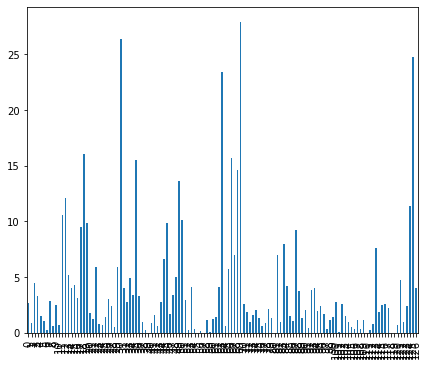

time: 1.49 s (started: 2023-05-17 14:49:16 +00:00)


In [47]:
data['TOTAL_mobil'].plot(kind='bar',figsize=(7,6));
data.shape

In [48]:
# convert weekyear column to datetime format
data['weekyear'] = pd.to_datetime(data['weekyear'] + '-1', format='%G-%V-%u')

# create a new DataFrame with all the possible weekyear values
start_weekyear = data['weekyear'].min()
end_weekyear = data['weekyear'].max()
all_weekyears = pd.date_range(start=start_weekyear, end=end_weekyear, freq='W-MON')
all_weekyears_df = pd.DataFrame({'weekyear': all_weekyears})

all_weekyears_df

# merge the two DataFrames
merged_data_df = pd.merge(all_weekyears_df, data, on='weekyear', how='outer')

# fill the missing values with NaN
#merged_data_df['TOTAL_mobil'].fillna(value=pd.np.nan, inplace=True)
#merged_data_df['TOTAL_mobil'].fillna(value=pd.np.nan, inplace=True)
#merged_data_df['TOTAL_mobil'].fillna(value=pd.np.nan, inplace=True)
#merged_data_df['TOTAL_mobil'].fillna(value=pd.np.nan, inplace=True)
merged_data_df = merged_data_df.set_index('weekyear', drop=True).sort_index()
merged_data_df.shape

(469, 4)

time: 15.7 ms (started: 2023-05-17 14:49:18 +00:00)


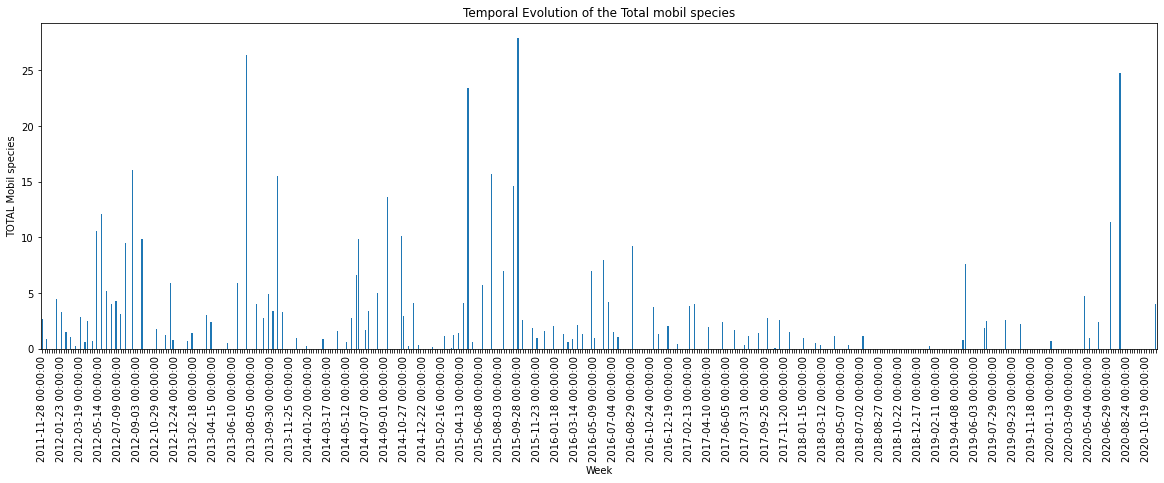

time: 2.6 s (started: 2023-05-17 14:49:18 +00:00)


In [49]:
ax = merged_data_df['TOTAL_mobil'].plot.bar(figsize=(20,6), legend=False)

# Create a xlabels list with some missing values
labels = [''] * len(merged_data_df.index)
labels[0:len(merged_data_df.index):8] = merged_data_df.index[0:len(merged_data_df.index):8]
ax.set_xticklabels(labels)

ax.set_title('Temporal Evolution of the Total mobil species')
ax.set_xlabel('Week')
ax.set_ylabel('TOTAL Mobil species')

plt.show()

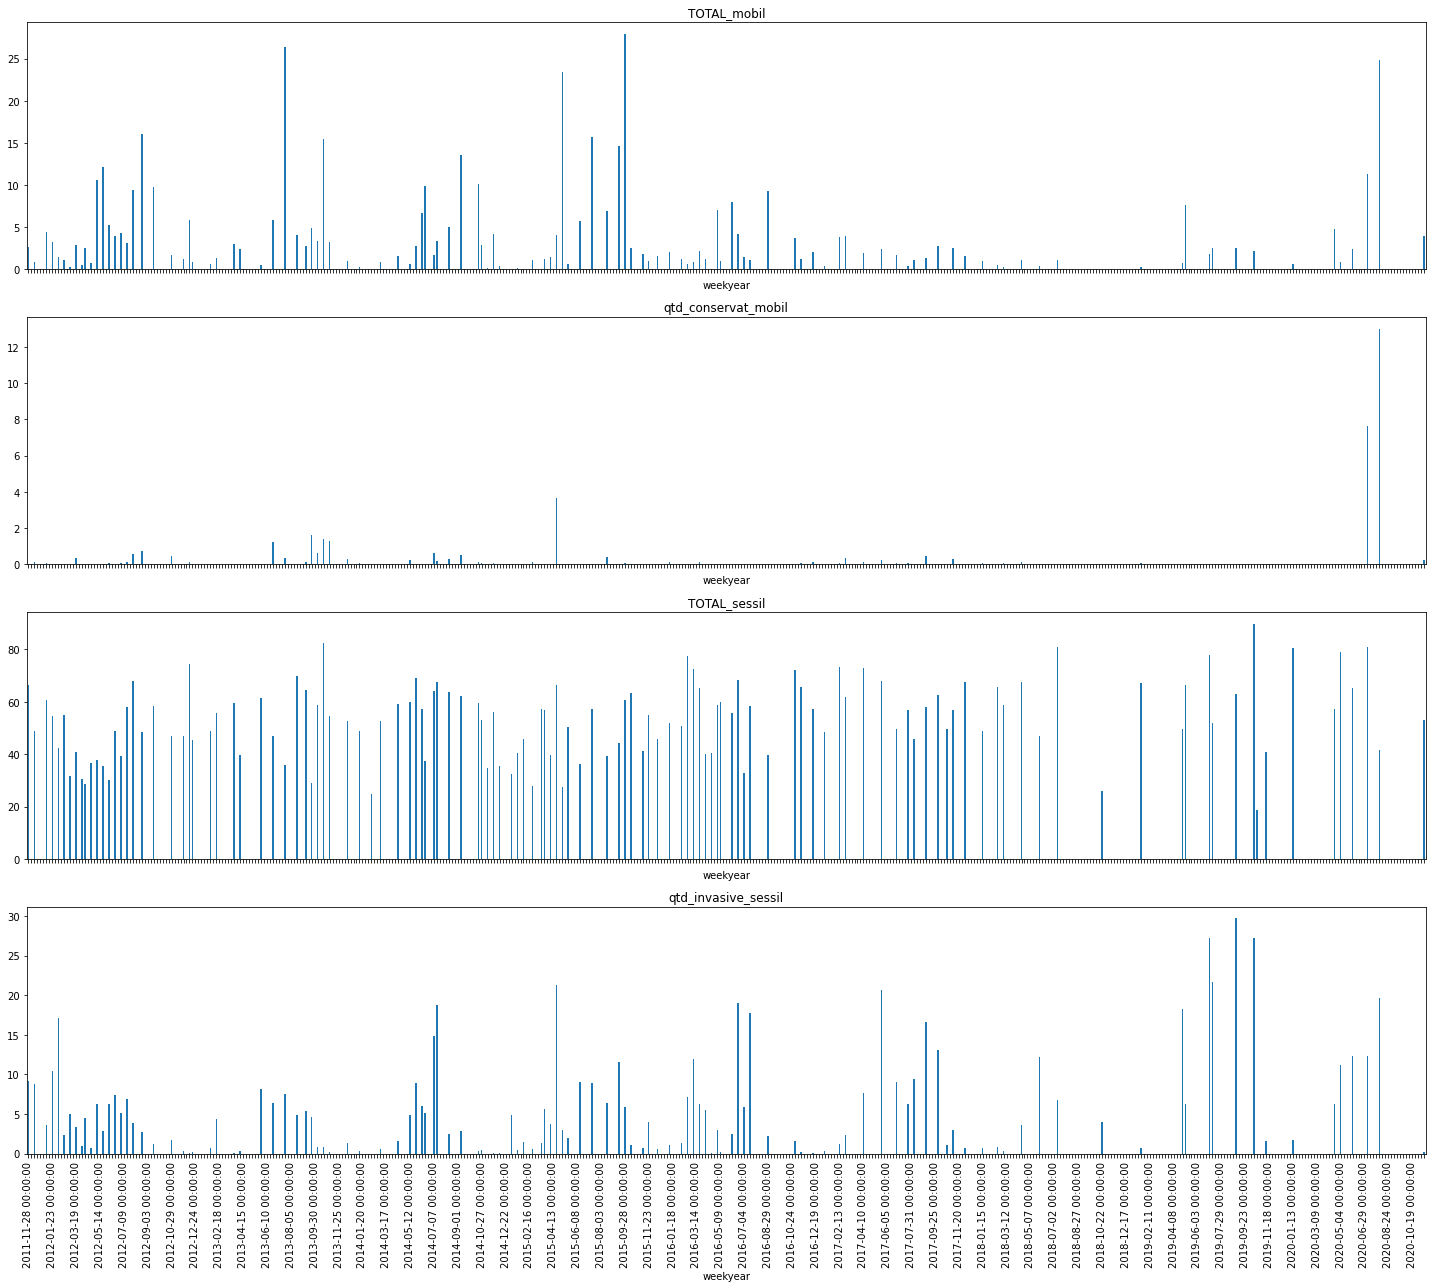

time: 11.5 s (started: 2023-05-17 14:49:20 +00:00)


In [50]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(20, 18))

merged_data_df['TOTAL_mobil'].plot.bar(ax=axs[0], legend=False)
axs[0].set_title('TOTAL_mobil')
axs[0].set_xticklabels([])

merged_data_df['qtd_conservat_mobil'].plot.bar(ax=axs[1], legend=False)
axs[1].set_title('qtd_conservat_mobil')
axs[1].set_xticklabels([])

merged_data_df['TOTAL_sessil'].plot.bar(ax=axs[2], legend=False)
axs[2].set_title('TOTAL_sessil')
axs[2].set_xticklabels([])

merged_data_df['qtd_invasive_sessil'].plot.bar(ax=axs[3], legend=False)
axs[3].set_title('qtd_invasive_sessil')

# Addapt the xlabls that appear
labels = [''] * len(merged_data_df.index)
labels[0:len(merged_data_df.index):8] = merged_data_df.index[0:len(merged_data_df.index):8]
axs[3].set_xticklabels(labels)

plt.tight_layout()

plt.show()
fig.savefig('Metrics_in_Time.png')

In [51]:
# Creation of a correlation matrix

df_matrix_corr = merged_df[['year',
 'season',
 'Water temperature (ºC)_mobil',
 'Tide_mobil',
 'Weather Condition_mobil',
 'Asparagopsis armata',
 'Osmundea pinnatifida',
 'Cladophora sp. ', 
 'Codium sp.',
 'Colpomenia sinuosa ', 
 'qtd_invasive_sessil',
 'qtd_noninvasive_sessil',
 'TOTAL_sessil',
 'Diplodus sp.',
 'Diplodus sargus',
 'Lipophrys pholis ' , 
 'Diplodus vulgaris',
 'Gobius sp.',
 'Diplodus cervinus',
 'qtd_conservat_mobil',
 'qtd_nonconservat_mobil',
 'TOTAL_mobil']]


# select the numeric columns in the dataframe
numeric_columns = df_matrix_corr.select_dtypes(include=np.number).columns

# select the categorical columns in the dataframe
categorical_columns = df_matrix_corr.select_dtypes(exclude=np.number).columns

# convert the categorical columns in dummy
df_dummy = pd.get_dummies(df_matrix_corr[categorical_columns])


df_encoded = pd.concat([df_matrix_corr[numeric_columns], df_dummy], axis=1)

# compute the correlation matrix
correlation_matrix = df_encoded.corr()


time: 14 ms (started: 2023-05-17 14:49:32 +00:00)


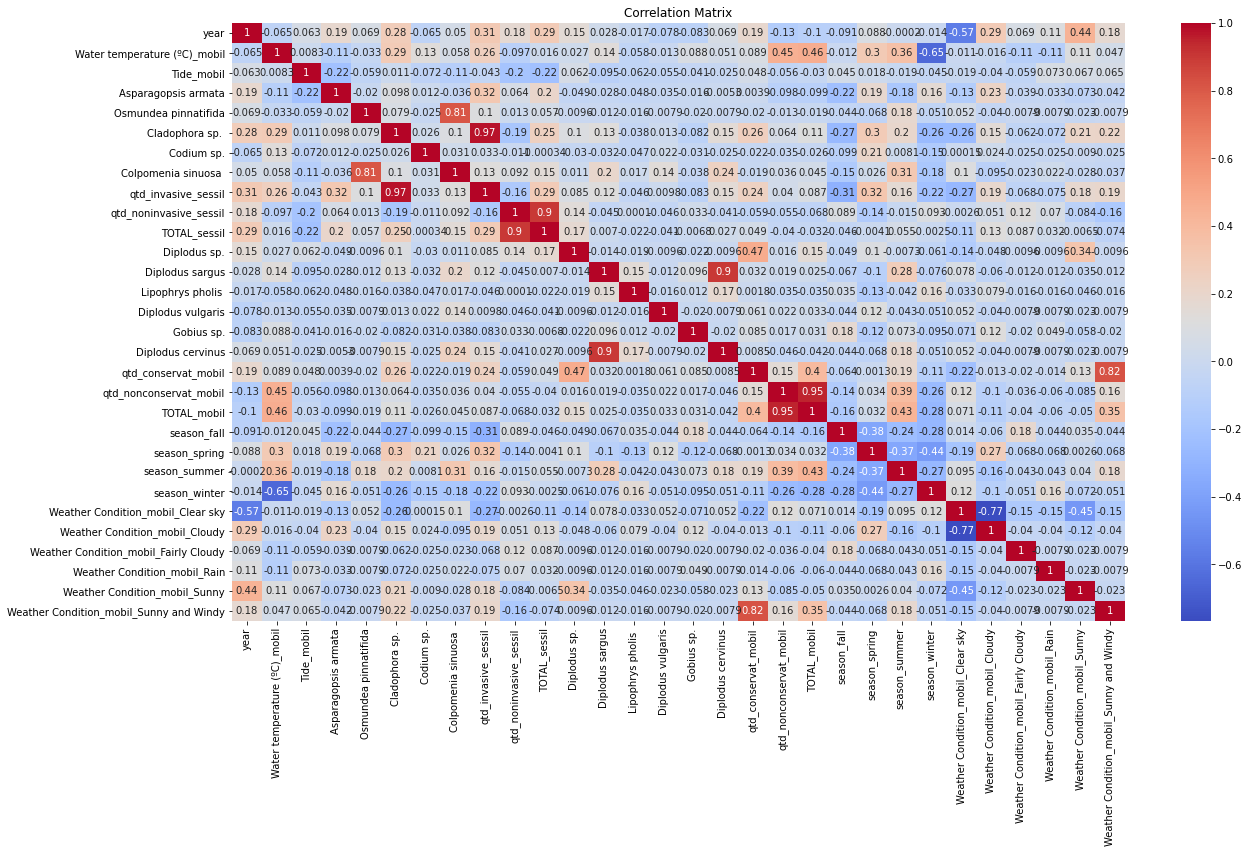

time: 4.79 s (started: 2023-05-17 14:49:32 +00:00)


In [52]:
#Draw the correlation matrix
import seaborn as sns
plt.figure(figsize=(20, 11))

sns_graphic = sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Matrix")
plt.show()

fig = sns_graphic.get_figure()
fig.savefig("out.png")

### Model

In [53]:
from sklearn.preprocessing import MinMaxScaler

time: 200 ms (started: 2023-05-17 14:49:37 +00:00)


In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

time: 2.54 s (started: 2023-05-17 14:49:37 +00:00)


1. Preparar os dados:
* Remover colunas desnecessárias (como a coluna "season", que pode não ser relevante para a previsão)
* Preencher os valores faltantes (como as semanas em que não há medidas) com um valor padrão (por exemplo, 0)
* Normalizar os dados para um intervalo de 0 a 1 (isso ajuda o modelo a convergir mais rapidamente e a melhorar a precisão da previsão)

2. Dividir os dados em conjuntos de treinamento e teste:
* Usar os dados anteriores a 2019 para treinar o modelo
* Usar os dados de 2019 até 2020-11-16 para testar o modelo

3. Construir o modelo LSTM:
* Definir o número de camadas LSTM e neurônios em cada camada
* Adicionar uma ou mais camadas densas para conectar a saída da camada LSTM à saída final
* Adicionar dropout para reduzir o overfitting
* Compilar o modelo, definindo a função de perda e o otimizador

4. Treinar o modelo:
* Usar o conjunto de treinamento para treinar o modelo, ajustando os pesos das camadas
* Monitorar o desempenho do modelo em cada época de treinamento e parar o treinamento quando o desempenho não melhora mais

5. Avaliar o modelo:
* Usar o conjunto de teste para avaliar o desempenho do modelo, comparando as previsões com os valores reais
* Calcular a métrica de avaliação, como RMSE ou MAE

6. Fazer previsões:
* Usar o modelo treinado para fazer previsões para datas futuras (2021-2025)
* Inserir as previsões em um novo dataframe e salvar em um arquivo CSV

In [55]:
df_base = merged_df[['weekyear',
 'Water temperature (ºC)_mobil',
 'Tide_mobil',
 'TOTAL_sessil',
 'TOTAL_mobil',
 'qtd_invasive_sessil',
 'qtd_conservat_mobil',
 ]]

df_base.head()

,weekyear,Water temperature (ºC)_mobil,Tide_mobil,TOTAL_sessil,TOTAL_mobil,qtd_invasive_sessil,qtd_conservat_mobil
0,2011-48,16.0,0.700,66.262292,2.685714,9.167411,0.000000
1,2011-50,16.0,0.895,48.965714,0.857143,8.785417,0.133333
2,2012-02,15.0,0.700,60.527619,4.451786,3.646905,0.035714
3,2012-04,17.0,0.600,54.431786,3.275000,10.406548,0.000000
4,2012-06,13.0,0.500,42.227018,1.487500,17.090357,0.000000


time: 15.9 ms (started: 2023-05-17 14:49:39 +00:00)


Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.9866
Epoch 2/100
1/1 [==============================] - 0s 37ms/step - loss: 0.9741
Epoch 3/100
1/1 [==============================] - 0s 31ms/step - loss: 0.9627
Epoch 4/100
1/1 [==============================] - 0s 28ms/step - loss: 0.9523
Epoch 5/100
1/1 [==============================] - 0s 29ms/step - loss: 0.9427
Epoch 6/100
1/1 [==============================] - 0s 29ms/step - loss: 0.9336
Epoch 7/100
1/1 [==============================] - 0s 27ms/step - loss: 0.9252
Epoch 8/100
1/1 [==============================] - 0s 28ms/step - loss: 0.9174
Epoch 9/100
1/1 [==============================] - 0s 28ms/step - loss: 0.9102
Epoch 10/100
1/1 [==============================] - 0s 23ms/step - loss: 0.9035
Epoch 11/100
1/1 [==============================] - 0s 24ms/step - loss: 0.8971
Epoch 12/100
1/1 [==============================] - 0s 25ms/step - loss: 0.8907
Epoch 13/100
1/1 [==============================] -

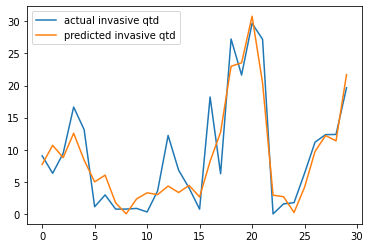

time: 6.49 s (started: 2023-05-17 14:49:39 +00:00)


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, Concatenate, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


df = df_base.copy()
df['weekyear'] = pd.to_datetime(df['weekyear'] + '-1', format='%G-%V-%u')
# Select the features
features = ["weekyear", "Water temperature (ºC)_mobil", "Tide_mobil","qtd_invasive_sessil"]
df = df[features]

# define the inputs
target = ["qtd_invasive_sessil"]
features = ["Water temperature (ºC)_mobil", "Tide_mobil"]
sequence_length = 30

# scale the data
target_scaler = StandardScaler().fit(df[target])
features_scaler = StandardScaler().fit(df[features])

df[target] = target_scaler.transform(df[target])
df[features] = features_scaler.transform(df[features])

# extract the input and output sequences
X_encoder = []  # past features and target values
X_decoder = []  # future features values
y = []          # future target values

for i in range(sequence_length, df.shape[0] - sequence_length):
    X_encoder.append(df[features + target].iloc[i - sequence_length: i])
    X_decoder.append(df[features].iloc[i: i + sequence_length])
    y.append(df[target].iloc[i: i + sequence_length])

X_encoder = np.array(X_encoder)
X_decoder = np.array(X_decoder)
y = np.array(y)

# define the encoder and decoder
def encoder(encoder_features):
    y = LSTM(units=100, return_sequences=True)(encoder_features)
    y = TimeDistributed(Dense(units=1))(y)
    return y

def decoder(decoder_features, encoder_outputs):
    x = Concatenate(axis=-1)([decoder_features, encoder_outputs])
    y = TimeDistributed(Dense(units=100, activation='relu'))(x)
    y = TimeDistributed(Dense(units=1))(y)
    return y

# build the model
encoder_features = Input(shape=X_encoder.shape[1:])
decoder_features = Input(shape=X_decoder.shape[1:])
encoder_outputs = encoder(encoder_features)
decoder_outputs = decoder(decoder_features, encoder_outputs)
model = Model([encoder_features, decoder_features], decoder_outputs)

# train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.fit([X_encoder, X_decoder], y, epochs=100, batch_size=128)

# extract the last predicted sequence
y_true = target_scaler.inverse_transform(y[-1, :])
y_pred = target_scaler.inverse_transform(model.predict([X_encoder, X_decoder])[-1, :])

# plot the last predicted sequence
plt.plot(y_true.flatten(), label='actual invasive qtd')
plt.plot(y_pred.flatten(), label='predicted invasive qtd')
plt.legend()
plt.show()

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.2530
Epoch 2/100
1/1 [==============================] - 0s 34ms/step - loss: 0.2437
Epoch 3/100
1/1 [==============================] - 0s 31ms/step - loss: 0.2351
Epoch 4/100
1/1 [==============================] - 0s 29ms/step - loss: 0.2272
Epoch 5/100
1/1 [==============================] - 0s 28ms/step - loss: 0.2199
Epoch 6/100
1/1 [==============================] - 0s 30ms/step - loss: 0.2133
Epoch 7/100
1/1 [==============================] - 0s 28ms/step - loss: 0.2074
Epoch 8/100
1/1 [==============================] - 0s 30ms/step - loss: 0.2021
Epoch 9/100
1/1 [==============================] - 0s 31ms/step - loss: 0.1975
Epoch 10/100
1/1 [==============================] - 0s 29ms/step - loss: 0.1934
Epoch 11/100
1/1 [==============================] - 0s 28ms/step - loss: 0.1900
Epoch 12/100
1/1 [==============================] - 0s 30ms/step - loss: 0.1871
Epoch 13/100
1/1 [==============================] -

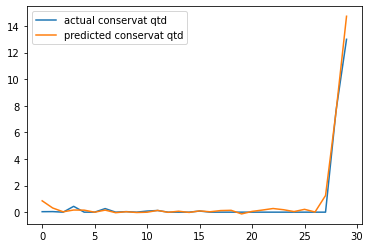

time: 6.23 s (started: 2023-05-17 14:49:46 +00:00)


In [57]:
df = df_base.copy()
df['weekyear'] = pd.to_datetime(df['weekyear'] + '-1', format='%G-%V-%u')
# select the features
features = ["weekyear", "Water temperature (ºC)_mobil", "Tide_mobil","qtd_conservat_mobil"]
df = df[features]

# define the inputs
target = ["qtd_conservat_mobil"]
features = ["Water temperature (ºC)_mobil", "Tide_mobil"]
sequence_length = 30

# scale the data
target_scaler = StandardScaler().fit(df[target])
features_scaler = StandardScaler().fit(df[features])

df[target] = target_scaler.transform(df[target])
df[features] = features_scaler.transform(df[features])

# extract the input and output sequences
X_encoder = []  # past features and target values
X_decoder = []  # future features values
y = []          # future target values

for i in range(sequence_length, df.shape[0] - sequence_length):
    X_encoder.append(df[features + target].iloc[i - sequence_length: i])
    X_decoder.append(df[features].iloc[i: i + sequence_length])
    y.append(df[target].iloc[i: i + sequence_length])

X_encoder = np.array(X_encoder)
X_decoder = np.array(X_decoder)
y = np.array(y)

# define the encoder and decoder
def encoder(encoder_features):
    y = LSTM(units=100, return_sequences=True)(encoder_features)
    y = TimeDistributed(Dense(units=1))(y)
    return y

def decoder(decoder_features, encoder_outputs):
    x = Concatenate(axis=-1)([decoder_features, encoder_outputs])
    y = TimeDistributed(Dense(units=100, activation='relu'))(x)
    y = TimeDistributed(Dense(units=1))(y)
    return y

# build the model
encoder_features = Input(shape=X_encoder.shape[1:])
decoder_features = Input(shape=X_decoder.shape[1:])
encoder_outputs = encoder(encoder_features)
decoder_outputs = decoder(decoder_features, encoder_outputs)
model = Model([encoder_features, decoder_features], decoder_outputs)

# train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.fit([X_encoder, X_decoder], y, epochs=100, batch_size=128)

# extract the last predicted sequence
y_true = target_scaler.inverse_transform(y[-1, :])
y_pred = target_scaler.inverse_transform(model.predict([X_encoder, X_decoder])[-1, :])

# plot the last predicted sequence
plt.plot(y_true.flatten(), label='actual conservat qtd')
plt.plot(y_pred.flatten(), label='predicted conservat qtd')
plt.legend()
plt.show()

## 🖼️ Visualisations

### Quantity of Zones measure in each week
Next we show how many zones are measured per week over time.
They vary between 1 to 5 Zones, for the weeks that we have measures.

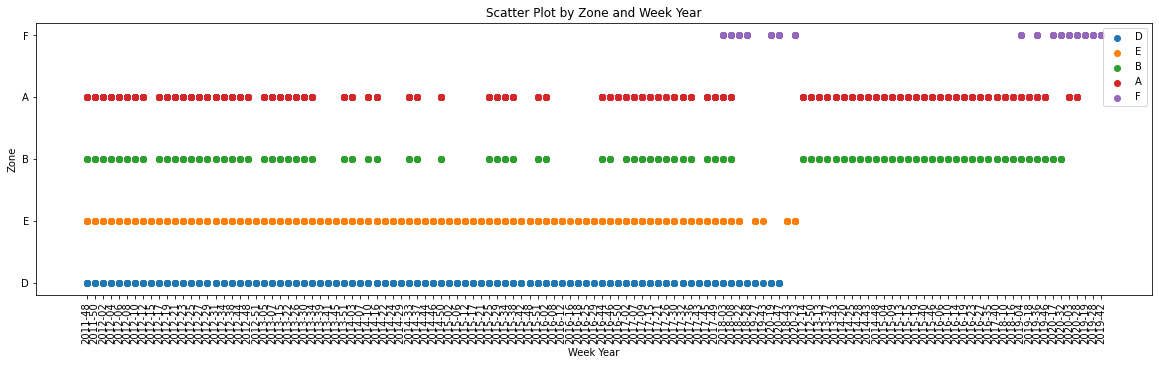

time: 1.25 s (started: 2023-05-17 14:49:52 +00:00)


In [58]:
#For sessil data
df = df_sessil

zones = df['Zone'].unique()

fig, ax = plt.subplots(figsize=(20, 5))
for zone in zones:
    df_zone = df[df['Zone'] == zone]
    plt.scatter(df_zone['weekyear'], df_zone['Zone'], label=zone)

plt.xticks(rotation=90)
plt.legend()
plt.xlabel('Week Year')
plt.ylabel('Zone')
plt.title('Scatter Plot by Zone and Week Year')

plt.show()

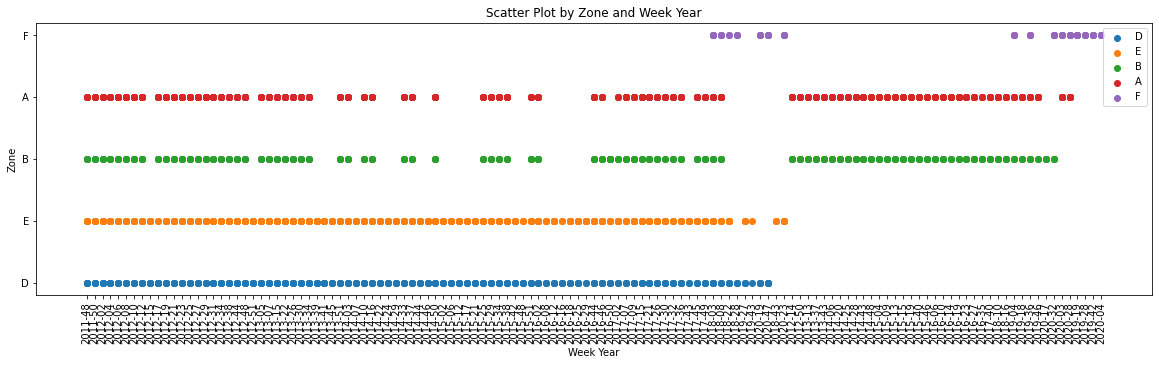

time: 1.77 s (started: 2023-05-17 14:49:53 +00:00)


In [59]:
#For Mobil data
df = df_mobil
zones = df['Zone'].unique()

fig, ax = plt.subplots(figsize=(20, 5))
for zone in zones:
    df_zone = df[df['Zone'] == zone]
    plt.scatter(df_zone['weekyear'], df_zone['Zone'], label=zone)


plt.xticks(rotation=90)
plt.legend()
plt.xlabel('Week Year')
plt.ylabel('Zone')
plt.title('Scatter Plot by Zone and Week Year')

# exibindo o gráfico
plt.show()

### Sessil Vizualizations
Vizualizations of the quantities of species over the weeks:
- stratified by invasive and non-invasive
- quantity of invasives and non-invasives crossed with water temperature and zone
- evolution over the years by season

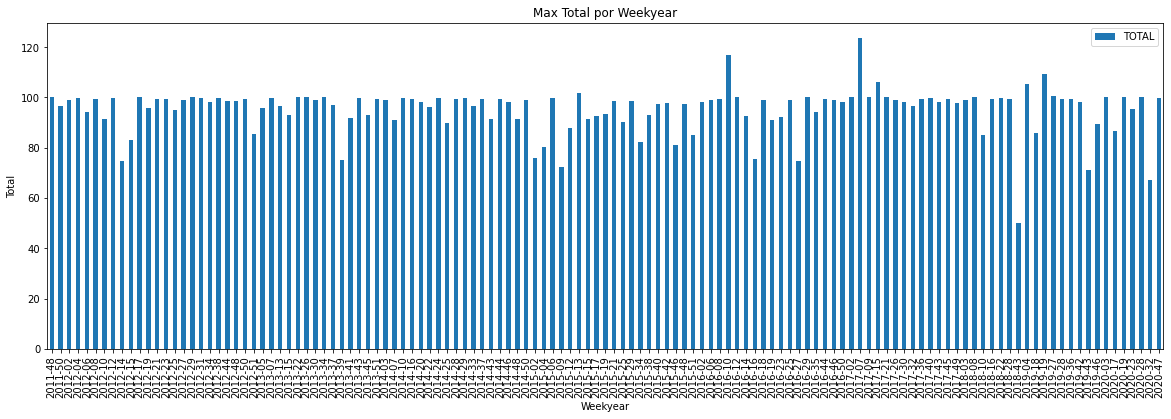

time: 3.86 s (started: 2023-05-17 14:49:55 +00:00)


In [60]:
df_resumed_byZoneWeek, df_resumed_byWeek = compute_resume_max_byZoneWeek_byWeek(df_sessil)
df_resumed_byWeek.plot(x='weekyear', y='TOTAL', kind='bar', figsize=(20,6))
plt.title('Max Total por Weekyear')
plt.xlabel('Weekyear')
plt.ylabel('Total')
plt.show()

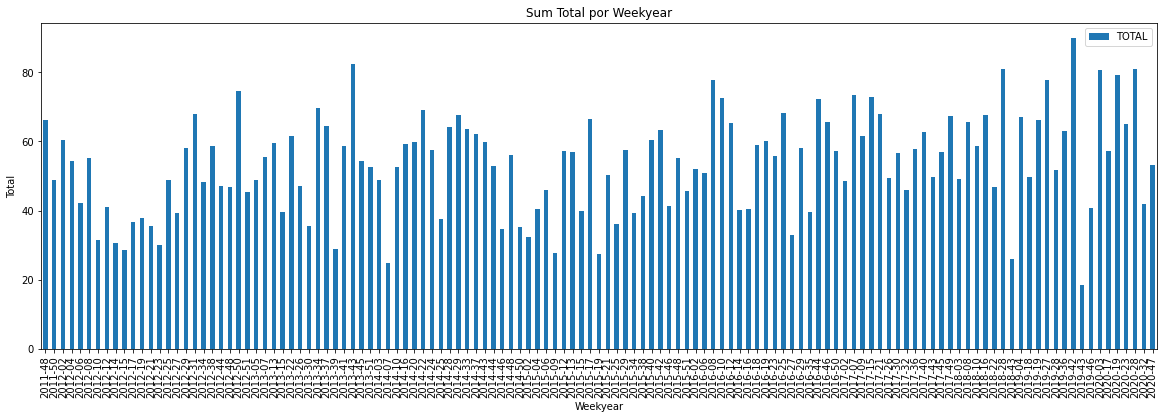

time: 4.58 s (started: 2023-05-17 14:49:59 +00:00)


In [61]:
df_resumed_byZoneWeek, df_resumed_byWeek = compute_resume_byZoneWeek_byWeek(df_sessil)
df_resumed_byWeek.plot(x='weekyear', y='TOTAL', kind='bar', figsize=(20,6))
plt.title('Sum Total por Weekyear')
plt.xlabel('Weekyear')
plt.ylabel('Total')
plt.show()

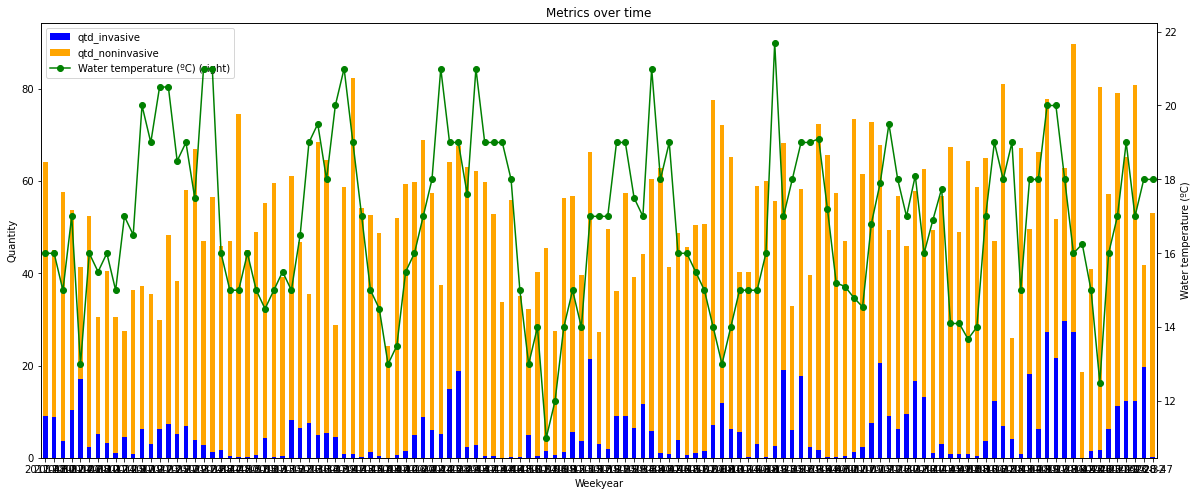

time: 1.98 s (started: 2023-05-17 14:50:04 +00:00)


In [62]:
df = df_resumed_byWeek

ax = df.plot.bar(x='weekyear', y=['qtd_invasive', 'qtd_noninvasive'],stacked =True, color=['blue', 'orange'],figsize=(20, 8))

df.plot(x='weekyear', y='Water temperature (ºC)', color='green', ax=ax, secondary_y=True, marker='o')

ax.set_xlabel('Weekyear')
ax.set_ylabel('Quantity')
ax.right_ax.set_ylabel('Water temperature (ºC)')
plt.title('Metrics over time')
plt.show()

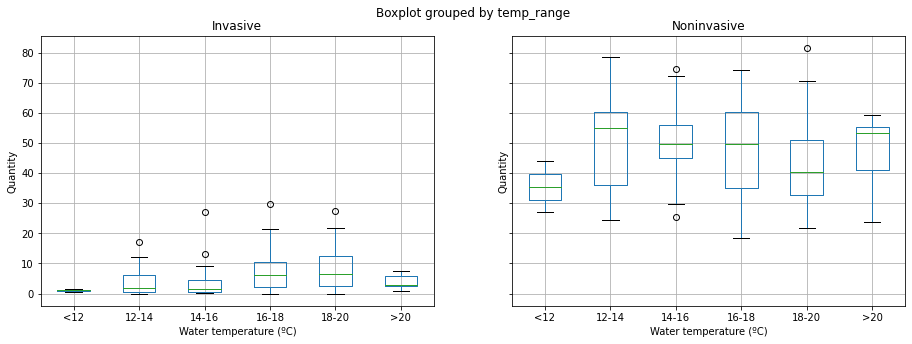

time: 353 ms (started: 2023-05-17 14:50:06 +00:00)


In [63]:
df = df_resumed_byWeek

bins = [10, 12, 14, 16, 18, 20, 22]
labels = ['<12', '12-14', '14-16', '16-18', '18-20', '>20']

df['temp_range'] = pd.cut(df['Water temperature (ºC)'], bins=bins, labels=labels)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))

df.boxplot(column='qtd_invasive', by='temp_range', ax=ax1)

ax1.set_title('Invasive')
ax1.set_xlabel('Water temperature (ºC)')
ax1.set_ylabel('Quantity')

df.boxplot(column='qtd_noninvasive', by='temp_range', ax=ax2)

ax2.set_title('Noninvasive')
ax2.set_xlabel('Water temperature (ºC)')
ax2.set_ylabel('Quantity')

plt.show()

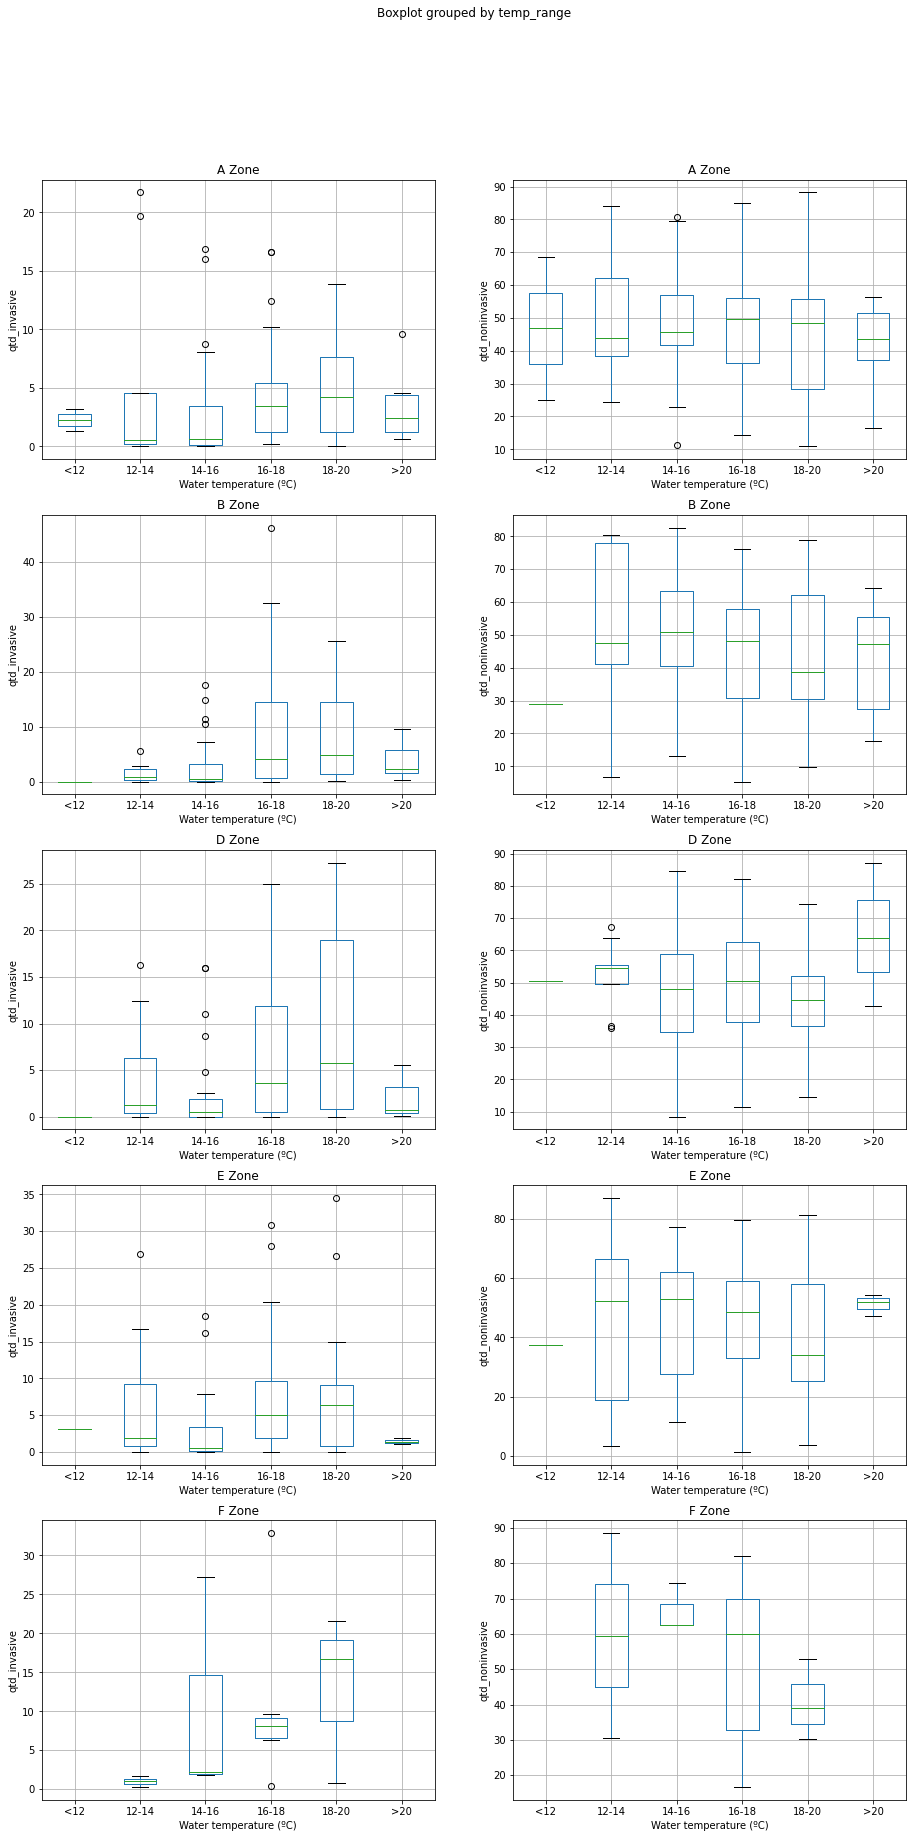

time: 1.56 s (started: 2023-05-17 14:50:06 +00:00)


In [64]:
df = df_resumed_byZoneWeek

bins = [10, 12, 14, 16, 18, 20, 22]
labels = ['<12', '12-14', '14-16', '16-18', '18-20', '>20']

df['temp_range'] = pd.cut(df['Water temperature (ºC)'], bins=bins, labels=labels)

fig, axs = plt.subplots(nrows=len(df['Zone'].unique()), ncols=2, figsize=(15, 6*len(df['Zone'].unique())))

for i, zone in enumerate(df['Zone'].unique()):
    zone_data = df[df['Zone'] == zone]
    ax = axs[i][0]
    zone_data.boxplot(column='qtd_invasive', by='temp_range', ax=ax)
    ax.set_xlabel('Water temperature (ºC)')
    ax.set_ylabel('qtd_invasive')
    ax.set_title(f'{zone} Zone')
    
    ax = axs[i][1]
    zone_data.boxplot(column='qtd_noninvasive', by='temp_range', ax=ax)
    ax.set_xlabel('Water temperature (ºC)')
    ax.set_ylabel('qtd_noninvasive')
    ax.set_title(f'{zone} Zone')
    
plt.show()

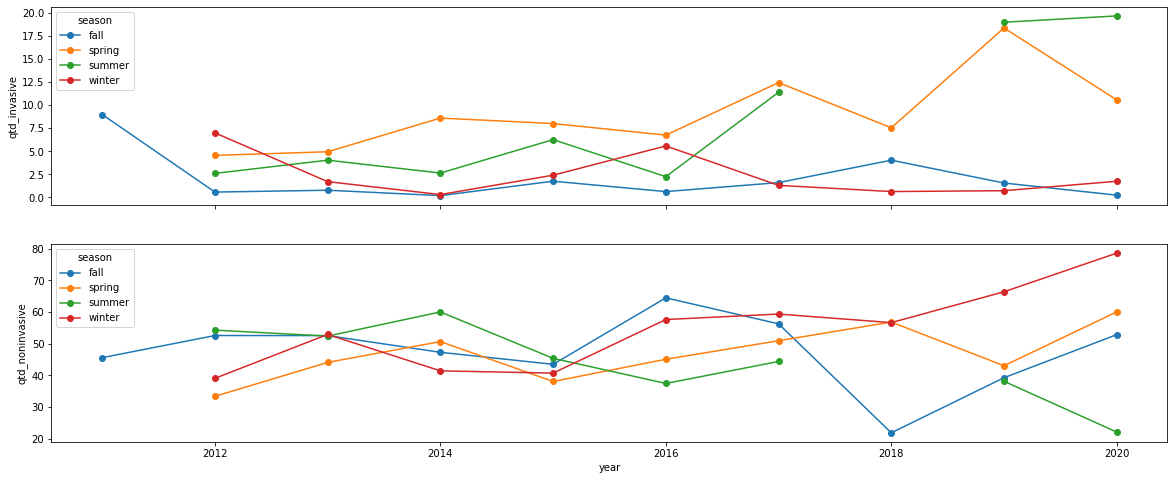

time: 368 ms (started: 2023-05-17 14:50:08 +00:00)


In [65]:
df = df_resumed_byWeek

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 8))

# plot for qtd_invasive
df.groupby(['year', 'season'])['qtd_invasive'].mean().unstack().plot(ax=ax1, marker='o')
ax1.set_ylabel('qtd_invasive')

# plot for qtd_noninvasive
df.groupby(['year', 'season'])['qtd_noninvasive'].mean().unstack().plot(ax=ax2, marker='o')
ax2.set_ylabel('qtd_noninvasive')

# set common x-axis label
plt.xlabel('year')

# show the plot
plt.show()

### Mobil Vizualizations
Vizualizations of the quantities of species over the weeks:
- stratified by invasive and non-invasive
- quantity of invasives and non-invasives crossed with water temperature and zone
- evolution over the years by season

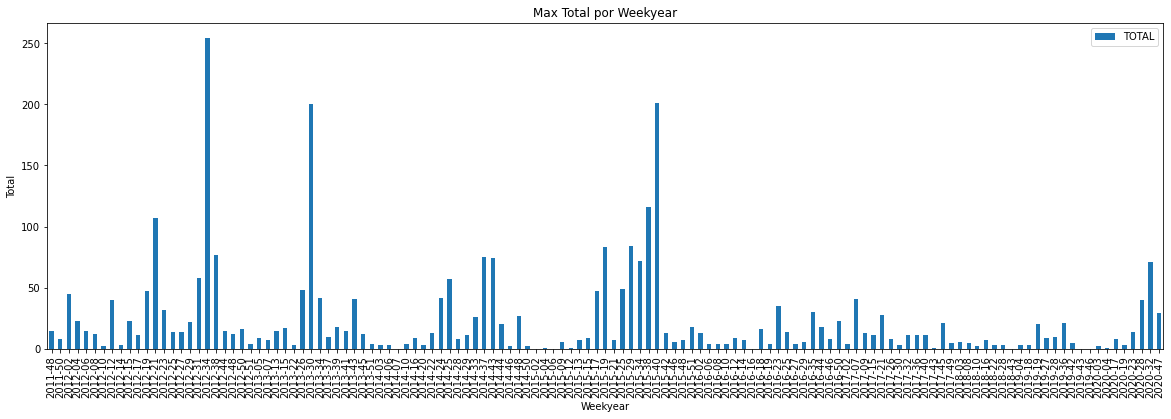

time: 4.04 s (started: 2023-05-17 14:50:08 +00:00)


In [66]:
df_resumed_byZoneWeek, df_resumed_byWeek = compute_resume_max_byZoneWeek_byWeek(df_mobil)

df = df_resumed_byWeek
df = df.set_index('weekyear', drop=True).reset_index() 
df.plot(x='weekyear', y='TOTAL', kind='bar', figsize=(20,6))
plt.title('Max Total por Weekyear')
plt.xlabel('Weekyear')
plt.ylabel('Total')
plt.show()

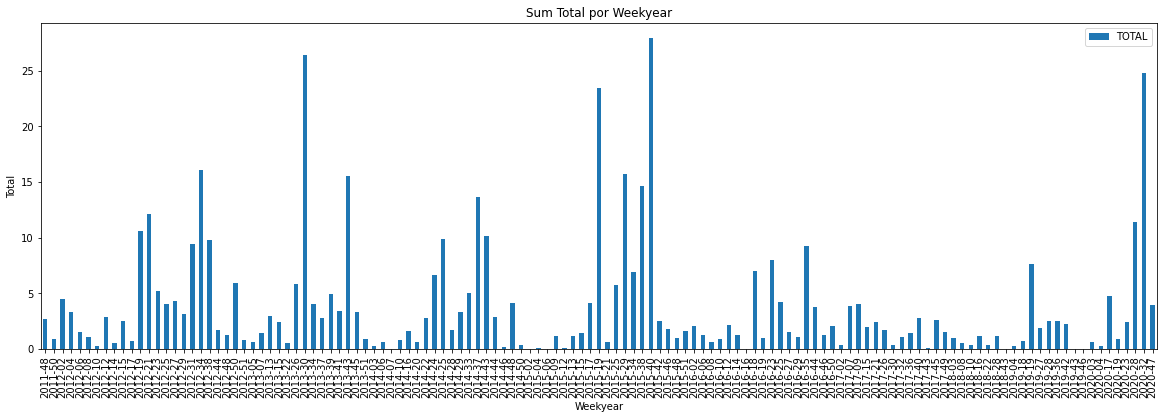

time: 3.35 s (started: 2023-05-17 14:50:12 +00:00)


In [67]:
df_resumed_byZoneWeek, df_resumed_byWeek = compute_resume_byZoneWeek_byWeek(df_mobil)
df_resumed_byWeek.plot(x='weekyear', y='TOTAL', kind='bar', figsize=(20,6))
plt.title('Sum Total por Weekyear')
plt.xlabel('Weekyear')
plt.ylabel('Total')
plt.show()

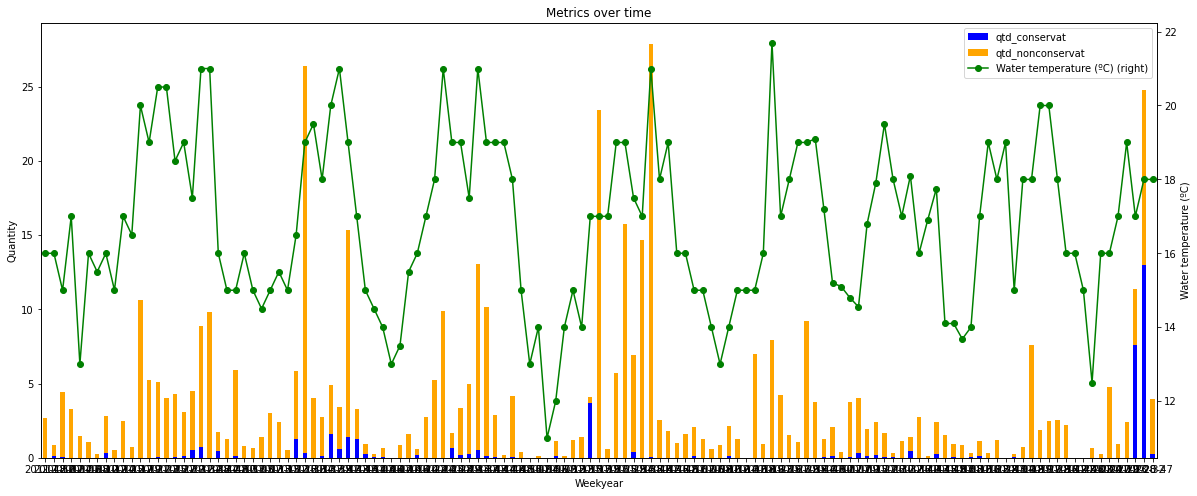

time: 1.96 s (started: 2023-05-17 14:50:15 +00:00)


In [68]:
df = df_resumed_byWeek

ax = df.plot.bar(x='weekyear', y=['qtd_conservat', 'qtd_nonconservat'],stacked =True, color=['blue', 'orange'],figsize=(20, 8))

df.plot(x='weekyear', y='Water temperature (ºC)', color='green', ax=ax, secondary_y=True, marker='o')

ax.set_xlabel('Weekyear')
ax.set_ylabel('Quantity')
ax.right_ax.set_ylabel('Water temperature (ºC)')
plt.title('Metrics over time')
plt.show()

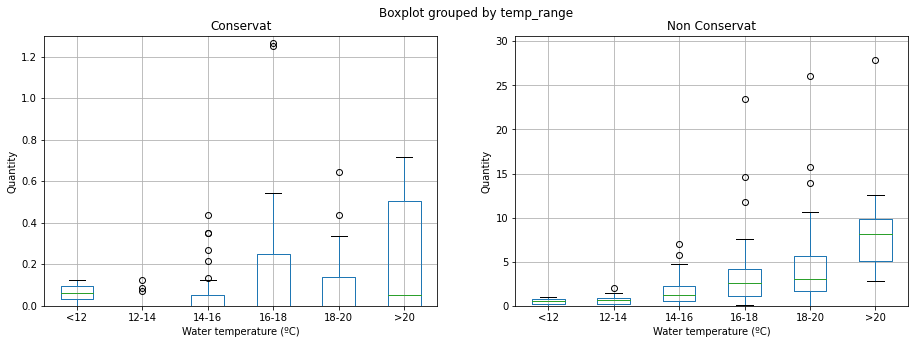

time: 356 ms (started: 2023-05-17 14:50:17 +00:00)


In [69]:
df = df_resumed_byWeek

bins = [10, 12, 14, 16, 18, 20, 22]
labels = ['<12', '12-14', '14-16', '16-18', '18-20', '>20']

df['temp_range'] = pd.cut(df['Water temperature (ºC)'], bins=bins, labels=labels)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))

df.boxplot(column='qtd_conservat', by='temp_range', ax=ax1)

ax1.set_ylim(0, df['qtd_conservat'].max() / 10)

ax1.set_title('Conservat')
ax1.set_xlabel('Water temperature (ºC)')
ax1.set_ylabel('Quantity')

df.boxplot(column='qtd_nonconservat', by='temp_range', ax=ax2)

ax2.set_ylim(0, df['qtd_nonconservat'].max() * 1.1)

ax2.set_title('Non Conservat')
ax2.set_xlabel('Water temperature (ºC)')
ax2.set_ylabel('Quantity')

plt.show()

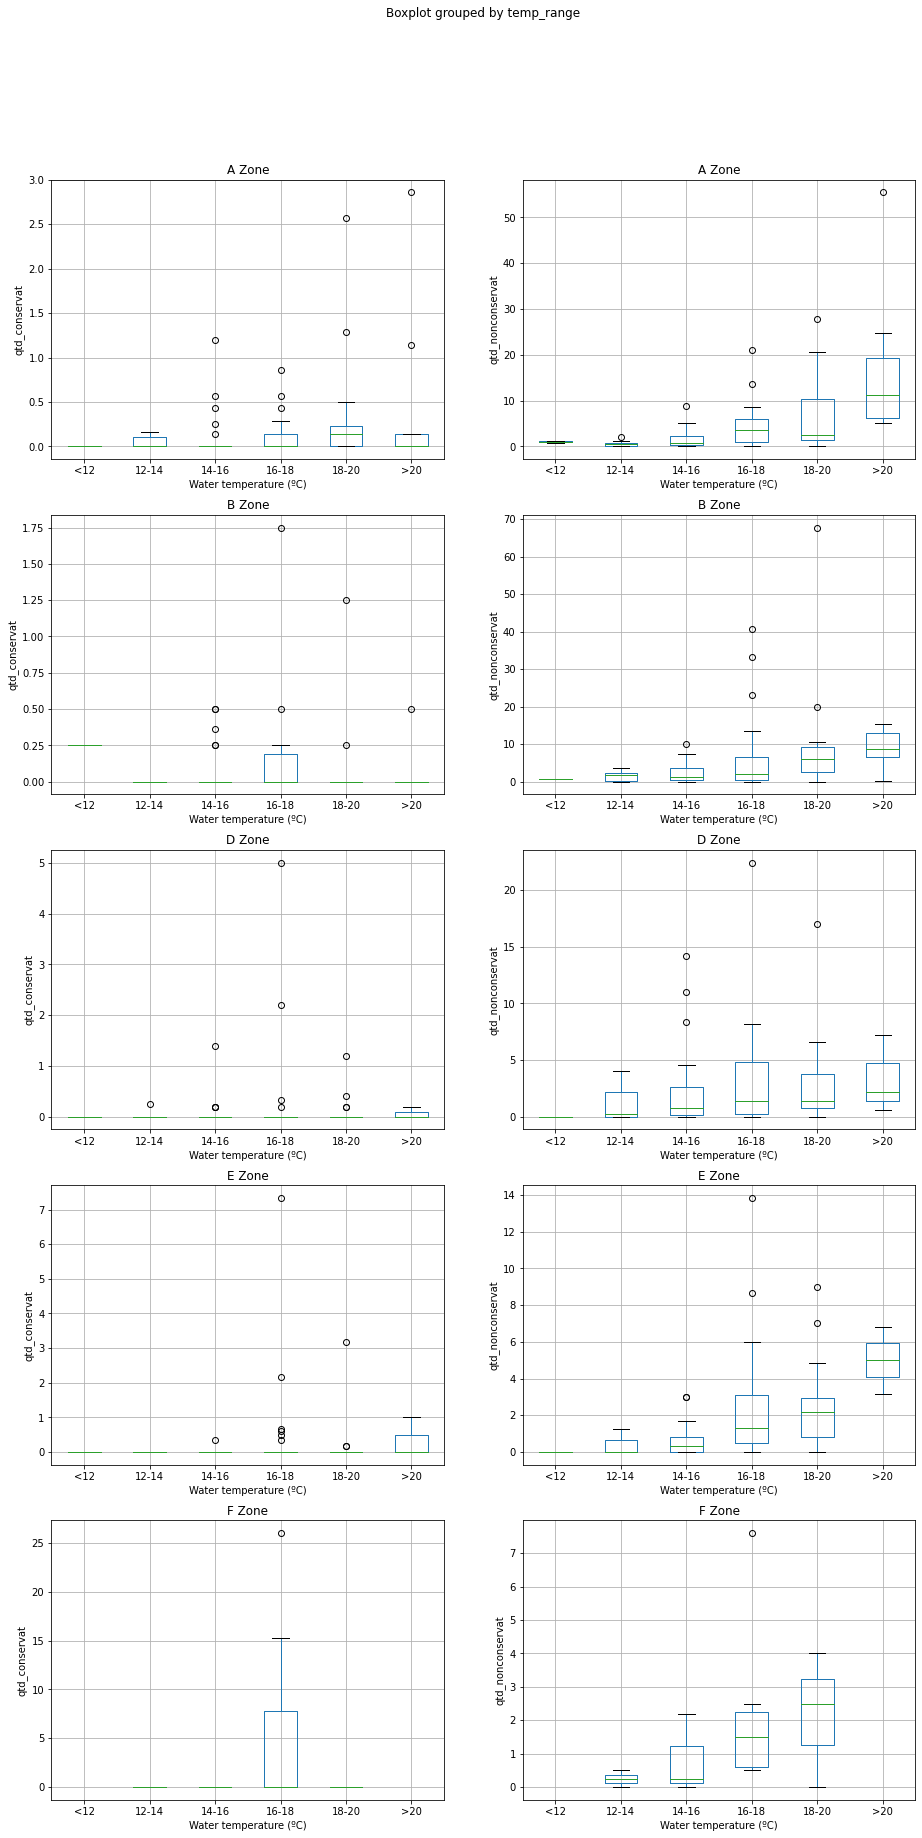

time: 2.04 s (started: 2023-05-17 14:50:18 +00:00)


In [70]:
df = df_resumed_byZoneWeek

bins = [10, 12, 14, 16, 18, 20, 22]
labels = ['<12', '12-14', '14-16', '16-18', '18-20', '>20']

df['temp_range'] = pd.cut(df['Water temperature (ºC)'], bins=bins, labels=labels)

fig, axs = plt.subplots(nrows=len(df['Zone'].unique()), ncols=2, figsize=(15, 6*len(df['Zone'].unique())))

# Loop through each unique zone and plot the data
for i, zone in enumerate(df['Zone'].unique()):
    zone_data = df[df['Zone'] == zone]
    ax = axs[i][0]
    zone_data.boxplot(column='qtd_conservat', by='temp_range', ax=ax)
    ax.set_xlabel('Water temperature (ºC)')
    ax.set_ylabel('qtd_conservat')
    ax.set_title(f'{zone} Zone')
    
    ax = axs[i][1]
    zone_data.boxplot(column='qtd_nonconservat', by='temp_range', ax=ax)
    ax.set_xlabel('Water temperature (ºC)')
    ax.set_ylabel('qtd_nonconservat')
    ax.set_title(f'{zone} Zone')
    
plt.show()

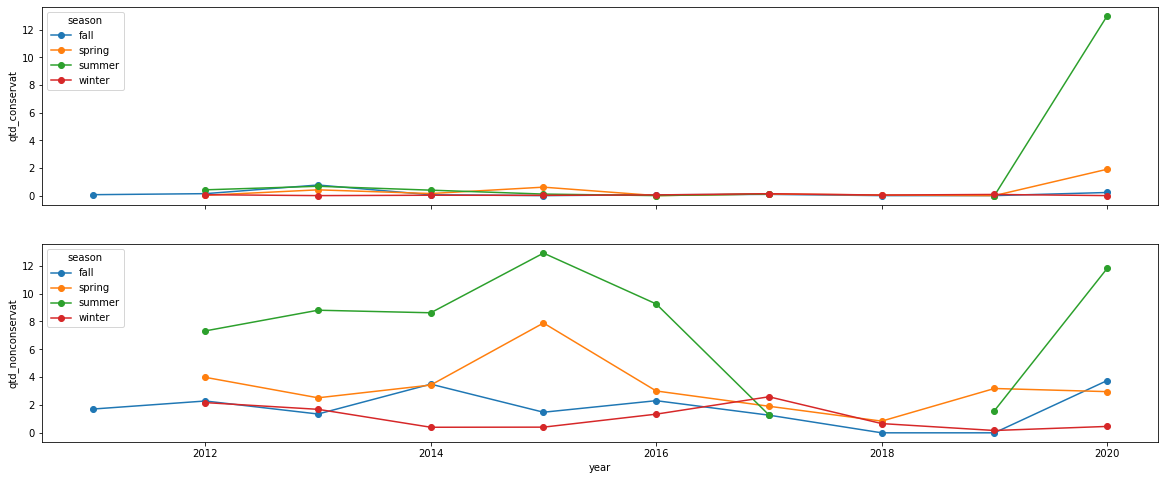

time: 315 ms (started: 2023-05-17 14:50:20 +00:00)


In [71]:
df = df_resumed_byWeek

# create subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 8))

# plot for qtd_invasive
df.groupby(['year', 'season'])['qtd_conservat'].mean().unstack().plot(ax=ax1, marker='o')
ax1.set_ylabel('qtd_conservat')

# plot for qtd_noninvasive
df.groupby(['year', 'season'])['qtd_nonconservat'].mean().unstack().plot(ax=ax2, marker='o')
ax2.set_ylabel('qtd_nonconservat')

# set common x-axis label
plt.xlabel('year')

# show the plot
plt.show()

## 👓 References
List all of the external links (even if they are already linked above), such as external datasets, papers, blog posts, code repositories and any other materials.